# "You think that's funny?" Topic modelling and text generation using Amazon and Netflix stand-up comedy scripts

Natural Language Generation (NLG) technologies are one of the most exciting and controversial application fields of machine learning algorithms. Applications based on language generation models range from auto-completing sentence softwares present on our smartphones to algorithms that automate the production of custom reports or that can generate content for websites, news, blog articles as well as being at the core of interactive conversations chatbots.

Over the past few years, research advancements in the field (e.g., transformer models) have hit the news numerous times both because of the astonishing progresses achieved by newly developed deep learning models in task such as generation of human-like text (see the case of [Liam Porr and GPT-3](https://www.technologyreview.com/2020/08/14/1006780/ai-gpt-3-fake-blog-reached-top-of-hacker-news/)) but also because of the ethical concerns (see the firing cases of [Margaret Mitchell and Timnit Gebru from Google](https://www.bbc.com/news/technology-56135817)) around the potential malicious use that could be done of these tools.

In this project, I wanted to dive into the world of natural language processing (NLP) and language generation models. To this end, this analysis explores topic extraction techniques as well as the construction of a language generation model on an atypical collection of documents: stand-up comedy scripts.

The goal is two-fold:
- a) The first is using standard Natural Language Processing (NLP) tecniques to investigate and summarize the topics debated in a corpus of 143 scripts of stand-up comedy shows released by Amazon and Netflix between 2013 and 2021;
- b) The second involves building on the knowledge acquired from the first part to create two deep learning models (specifically, two Recurrent Neural Network models with different architectures) and test the language capabilities of the most performing one in generating some new text.

Specifically, the notebook is divided in 5 sections:
- **1) Construction of the dataset**
- **2) Exploratory Data Analysis**
- **3) Topic modelling**
- **4) Text generation**
- **5) Conclusions**

# 1) Construction of the dataset

In this section, I have built the dataset used in this project. To do that, I combined the list of the stand-up comedy specials and their release date extracted from Wikipedia (`List_stand_up_comedy_full.csv` file) together with the text of the shows extracted by a series of .srt files (e.g., subtitles scripts) retrieved from the croudsourced community Subscene.com.

The final dataframe is then saved in the file `Stand_up_comedy_dataset.csv`.

The final dataset for the analysis contains the following features:

| Column name | Datatype | Definition |
| :- | :- | :- |
| `Title` | object | Title of the stand-up comedy special. |
| `Producer` | object | Platform that produced and released the show. |
| `Comedian` | object | Name and surname of the comedian. |
| `Gender` | object | Gender of the comedian. |
| `Release date` | object | Release date of the show. |
| `Original language` | object | Original language of the audio of the show.|
| `Text` | object | Full text/transcript of the show. |
| `Len_Hours` | int64 | Number of runtime hours. |
| `Len_Minutes` | int64 | Number of runtime minutes. |
| `Len_Minutes` | int64 | Number of runtime seconds. |
| `File_name` | object | Name of the .srt file (subtitles/transcript) in the working folder.|


The sources used to construct this dataset are Wikipedia (i.e., [Amazon stand-up comedy specials list](https://en.wikipedia.org/wiki/List_of_Amazon_original_programming#Stand-up_comedy_specials) and [Netflix stand up comedy list](https://en.wikipedia.org/wiki/List_of_Netflix_original_stand-up_comedy_specials)) for the first six features listed above. The remaining five features have been instead extracted from `.srt` files (subtitles files) downloaded from the website [Subscene.com](https://subscene.com). Subscene is a crowdsourced community of translators that hosts thousands of transcripts produced by its members. These `.srt` files contain the audio transcript in English language of the show and information on the lenght/timing of each sentence present in the show.

Notice that the dataset includes all the stand-up comedy shows for which an English transcript (.srt file) was available on Subscene. The stand-up comedy specials that do not meet this criterion were not included in the dataset.

In [1]:
import pysrt # Necessary to read .srt files
from tqdm import tqdm # Progress bar for loop
import os
import re
import string
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import list of stand up shows from .csv file (source: Wikipedia + manual integrations/adjustments)
df = pd.read_csv('List_stand_up_comedy_full.csv')
print('Total number of stand-up comedy shows:', df.shape[0])
df.head()

Total number of stand-up comedy shows: 143


,Title,Release date,Original language,Producer,Gender,File_name
0,Adam DeVine: Best Time of Our Lives,"June 18, 2019",English,Netflix,M,Adam.Devine.Best.Time.of.Our.Lives.2019.720p.W...
1,Adam Sandler: 100% Fresh,"October 23, 2018",English,Netflix,M,Adam.Sandler.100.Percent.Fresh.2018.WEBRip.x26...
2,Adel Karam: Live From Beirut,"March 1, 2018",Arabic,Netflix,M,Adel_Karam_Live_From_Beirut_En_en
3,Afonso Padilha: Classless,"September 3, 2020",Portuguese,Netflix,M,Afonso.Padilha.Classless.2020
4,Alex Fernández: The Best Comedian in the World,"January 23, 2020",Spanish,Netflix,M,Alex.Fernández.The.Best.Comedian.in.the.World....


In [3]:
# Example .srt file
example = pysrt.open('Stand_up_specials_subs/Ali.Wong.Baby.Cobra.2016.720p.WEBRip.x264-JAWN.srt')
print('Starting time of sentence in position 0:', example[0].start)
print('Ending time of sentence in position 0:', example[0].end)
print('\nSentence example up to position 0:\n\n', example[0].text)

Starting time of sentence in position 0: 00:00:05,589
Ending time of sentence in position 0: 00:00:09,885

Sentence example up to position 0:

 [male announcer] <i>Ladies and gentlemen,</i>
<i>please welcome to the stage: Ali Wong!</i>


## 1.1) Extract text data from .srt files and create dataset for analysis

In [4]:
# Define cleaning function for .srt text files

def clean_srt(text):
    text = text.encode("ascii", "ignore") # Remove non-ASCII characters
    text = text.decode()
    text = text.replace('\n', ' ') # Remove new row escape
    text = re.sub(r'<[^>]+>', '', text) # Eliminate text within < > characters (often contaning info on subs font/color)
    text = re.sub(r'\[[^]]+\]', '', text) # Eliminate text within squared brackets (often contaning audio description for hearing-impaired individuals)
    text = re.sub(r'\([^)]+\)', '', text) # Eliminate text within parentheses (often contaning audio description for hearing-impaired individuals)
    text = text.replace('-', '') # Remove dialogue dashes
    text = ' '.join(text.split()) # Reduce all double/triple whitespacing to single
    return text

In [5]:
# Clean_srt function test on example file
clean_srt(example[0].text)

'Ladies and gentlemen, please welcome to the stage: Ali Wong!'

In [6]:
# Extract text data from .srt files and add to the dataset

main_dir = 'Stand_up_specials_subs'

# Get file names from folders
file_path = [os.path.join(root,f) for root,dirs,files in os.walk(main_dir) for f in files]

text_file = []
file_names = []
show_lenght = []


for file in tqdm(file_path):
    
    # Get file name to use as common column to merge with df
    file_name = os.path.basename(file)
    file_names.append(file_name)
    
    # Open .srt file
    subs = pysrt.open(file, encoding='iso-8859-1')
    
    # Extract text content and append to list
    text = subs.text
    text = clean_srt(text)
    text_file.append(text)
    
    # Extract lenght
    lenght = subs[len(subs)-1].end
    show_lenght.append(lenght)


# Transform list in a dataframe and rename columns 
df_fn = pd.DataFrame(file_names)
df_len = pd.DataFrame(show_lenght)
df_txt = pd.DataFrame(text_file)
extract_df = pd.concat([df_fn, df_len, df_txt], ignore_index=True, axis=1).rename(columns={0 :'File_name', 1 : 'Len_Hours', 2 : 'Len_Minutes', 3 : 'Len_Seconds', 4 :'Len_Milliseconds', 5 : 'Text'})

print('Number of stand-up comedy shows with text:', extract_df.shape[0])
extract_df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:06<00:00, 22.25it/s]

Number of stand-up comedy shows with text: 143


,File_name,Len_Hours,Len_Minutes,Len_Seconds,Len_Milliseconds,Text
0,Adam.Devine.Best.Time.of.Our.Lives.2019.720p.W...,0,57,44,711,"Hey, man. How are you? Thank you. Let's do thi..."
1,Adam.Sandler.100.Percent.Fresh.2018.WEBRip.x26...,1,13,38,580,"Okay, ready, and... Take your own cue, Adam. A..."
2,Adel_Karam_Live_From_Beirut_En_en.srt,0,57,23,600,A NETFLIX COMEDY SPECIAL CASINO LEBANON Hello....
3,Afonso.Padilha.Classless.2020.srt,1,2,24,699,"I'm so happy to be recording this for Netflix,..."
4,Alex.Fernández.The.Best.Comedian.in.the.World....,0,51,0,432,A NETFLIX ORIGINAL COMEDY SPECIAL ALEX FERNNDE...


## 1.2) Merge dataframe with extracted text data and stand-up shows dataset

In [7]:
# Remove file extension from file name for merging
extract_df['File_name'] = extract_df['File_name'].str.replace('.srt', '', regex=False)

# Concatenate the two dataframes to obtain final dataset
df_final = pd.merge(df, extract_df, how='left', on='File_name')

# Generate comedian's name column
df_final['Comedian'] =  df_final['Title'].str.split(':', expand=True)[0]

# Reorder columns, drop milliseconds column and print basic info
df_final = df_final[['Title', 'Producer', 'Comedian', 'Gender', 'Release date', 'Original language',
                     'Text', 'Len_Hours', 'Len_Minutes', 'Len_Seconds', 'File_name']]

print('Final dataset shape:\n', df_final.shape)
df_final.info()
df_final.head()

Final dataset shape:
 (143, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 11 columns):
Title                143 non-null object
Producer             143 non-null object
Comedian             143 non-null object
Gender               143 non-null object
Release date         143 non-null object
Original language    143 non-null object
Text                 143 non-null object
Len_Hours            143 non-null int64
Len_Minutes          143 non-null int64
Len_Seconds          143 non-null int64
File_name            143 non-null object
dtypes: int64(3), object(8)
memory usage: 13.4+ KB


,Title,Producer,Comedian,Gender,Release date,Original language,Text,Len_Hours,Len_Minutes,Len_Seconds,File_name
0,Adam DeVine: Best Time of Our Lives,Netflix,Adam DeVine,M,"June 18, 2019",English,"Hey, man. How are you? Thank you. Let's do thi...",0,57,44,Adam.Devine.Best.Time.of.Our.Lives.2019.720p.W...
1,Adam Sandler: 100% Fresh,Netflix,Adam Sandler,M,"October 23, 2018",English,"Okay, ready, and... Take your own cue, Adam. A...",1,13,38,Adam.Sandler.100.Percent.Fresh.2018.WEBRip.x26...
2,Adel Karam: Live From Beirut,Netflix,Adel Karam,M,"March 1, 2018",Arabic,A NETFLIX COMEDY SPECIAL CASINO LEBANON Hello....,0,57,23,Adel_Karam_Live_From_Beirut_En_en
3,Afonso Padilha: Classless,Netflix,Afonso Padilha,M,"September 3, 2020",Portuguese,"I'm so happy to be recording this for Netflix,...",1,2,24,Afonso.Padilha.Classless.2020
4,Alex Fernández: The Best Comedian in the World,Netflix,Alex Fernández,M,"January 23, 2020",Spanish,A NETFLIX ORIGINAL COMEDY SPECIAL ALEX FERNNDE...,0,51,0,Alex.Fernández.The.Best.Comedian.in.the.World....


In [8]:
# Save to .csv file
df_final.to_csv('Stand_up_comedy_dataset.csv', index=False)

# 2) Exploratory Data Analysis

The Exploratory Data Analysis (EDA) is made of two parts:
- 1) A general overview of the number of stand up shows included in the study, their authors and producers;
- 2) An explorative analysis of the text data of all the stand-up shows NLP tecniques which will include:
    - Histograms of the distribution of words across documents;
    - Histograms of the distribution of sentences across documents;
    - Word clouds to study tokens and stopwords frequency.
    - Bar chart of the most common noun-chunks (i.e., noun plus close words related to it) present in the text.
    - Word clouds of lemmatized tokens which are tagged by the POS tagger as proper names, names or adjectives to further shed light on the content of the stand-up comedy scripts.

To perform the tasks mentioned in point 2), I will use the `SpaCy` language model. `SpaCy` is a powerful library that allows to perform many NLP tasks easily. It provides complete and flexible language processing pipelines to tokenize, part-of-speech (POS) tagging, dependency parsing, lemmatize texts as well as other tools that facilitate the exploration of text data.

## 2.1) General overview of the dataset

The EDA on the dataset of non-textual features provides some interesting insights on the characteristics of the stand-up comedy shows and their comedians:

- The first clear observation is that the vast majority of the shows have been produced by Netflix between 2015 and 2020. The time frame of the shows in itself could already suggest that popular topics at the center of the public debate in those years (e.g., terrorist attacks, American elections, Me Too movement) are likely to have been discussed in the shows.

- Most of the stand-up shows have English as original audio language. This is a confirmation of the fact that stand-up comedy is a phenomenon born and mostly diffused in English speaking countries. This could suggest that people, events and cultural references discussed in the shows are probably going to be related to English-speaking countries such as the US, UK, Australia, etc.

- The dataset is unbalanced on several dimensions. Comedians are predominantly male (77%) and there are also several comedians in the sample that produced more than one stand-up special. These elements might have an influence on both the topic modelling analysis and on the text generation.

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [10]:
# Open Stand_up_comedy dataset
df = pd.read_csv('Stand_up_comedy_dataset.csv')
print('Dataset shape:\n', df.shape)
df.info()
df.head(3)

Dataset shape:
 (143, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 11 columns):
Title                143 non-null object
Producer             143 non-null object
Comedian             143 non-null object
Gender               143 non-null object
Release date         143 non-null object
Original language    143 non-null object
Text                 143 non-null object
Len_Hours            143 non-null int64
Len_Minutes          143 non-null int64
Len_Seconds          143 non-null int64
File_name            143 non-null object
dtypes: int64(3), object(8)
memory usage: 12.4+ KB


,Title,Producer,Comedian,Gender,Release date,Original language,Text,Len_Hours,Len_Minutes,Len_Seconds,File_name
0,Adam DeVine: Best Time of Our Lives,Netflix,Adam DeVine,M,"June 18, 2019",English,"Hey, man. How are you? Thank you. Let's do thi...",0,57,44,Adam.Devine.Best.Time.of.Our.Lives.2019.720p.W...
1,Adam Sandler: 100% Fresh,Netflix,Adam Sandler,M,"October 23, 2018",English,"Okay, ready, and... Take your own cue, Adam. A...",1,13,38,Adam.Sandler.100.Percent.Fresh.2018.WEBRip.x26...
2,Adel Karam: Live From Beirut,Netflix,Adel Karam,M,"March 1, 2018",Arabic,A NETFLIX COMEDY SPECIAL CASINO LEBANON Hello....,0,57,23,Adel_Karam_Live_From_Beirut_En_en


In [11]:
# Create variable total runtime lenght in minutes
df['Len_total'] = (df['Len_Hours']*60)+df['Len_Minutes']+(df['Len_Seconds']/60)

# Apply correct datatype to relase date
df['Release date'] = pd.to_datetime(df['Release date'])
df['Release month'] = df['Release date'].dt.strftime('%B')
df['Release year'] = df['Release date'].dt.strftime('%Y')

df.head(3)

,Title,Producer,Comedian,Gender,Release date,Original language,Text,Len_Hours,Len_Minutes,Len_Seconds,File_name,Len_total,Release month,Release year
0,Adam DeVine: Best Time of Our Lives,Netflix,Adam DeVine,M,2019-06-18,English,"Hey, man. How are you? Thank you. Let's do thi...",0,57,44,Adam.Devine.Best.Time.of.Our.Lives.2019.720p.W...,57.733333,June,2019
1,Adam Sandler: 100% Fresh,Netflix,Adam Sandler,M,2018-10-23,English,"Okay, ready, and... Take your own cue, Adam. A...",1,13,38,Adam.Sandler.100.Percent.Fresh.2018.WEBRip.x26...,73.633333,October,2018
2,Adel Karam: Live From Beirut,Netflix,Adel Karam,M,2018-03-01,Arabic,A NETFLIX COMEDY SPECIAL CASINO LEBANON Hello....,0,57,23,Adel_Karam_Live_From_Beirut_En_en,57.383333,March,2018


#### Dashboard 1: Stand-up comedy shows

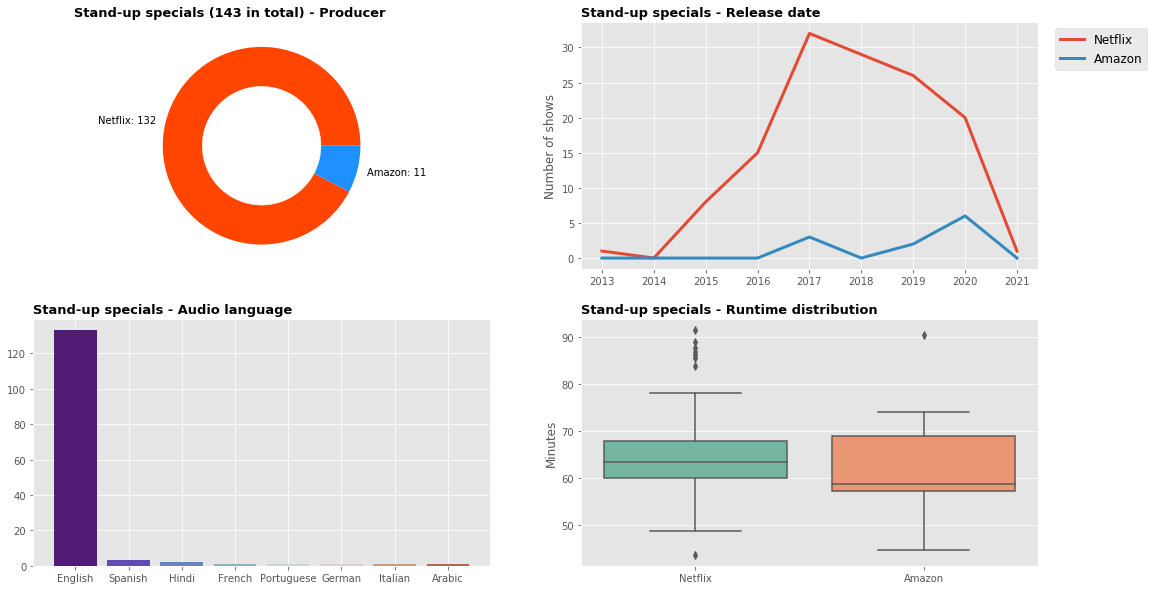

In [12]:
## General EDA charts panel (1) - Stand-up shows 

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 10 # set default font size

fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(18, 10))#set subplot and fig size

## AX1 - Producer

producer_num = list(df['Producer'].value_counts())
lbls = ['Netflix: {}'.format(producer_num[0]), 'Amazon: {}'.format(producer_num[1])]
colors = ['orangered', 'dodgerblue']

ax1.pie(producer_num, labels=['Netflix: {}'.format(producer_num[0]), 'Amazon: {}'.format(producer_num[1])], colors=colors)
ax1.add_artist(plt.Circle((0, 0), 0.6, color='white')) # white circle at the centre
ax1.set_title('Stand-up specials ({} in total) - Producer'.format(df.shape[0]), fontweight='bold', fontsize=13, loc='right')


## AX2- Original language

lang_num = list(df['Original language'].value_counts())
lang_lbl = list(df['Original language'].value_counts().index)

ax2.bar(lang_lbl, lang_num, color=sns.color_palette("twilight_shifted", 10))
ax2.tick_params(labelsize=10)
ax2.set_title('Stand-up specials - Audio language', fontweight='bold', fontsize=13, loc='left')


## AX3 - Number of shows overtime 

# Prepate lists for chart and fill with zero in years with NaN
years = range(2013, 2022)
netflix = list(df[df['Producer']=='Netflix'].groupby('Release year')['Title'].count())
netflix.insert(1, 0) 

amazon = list(df[df['Producer']=='Amazon'].groupby('Release year')['Title'].count())
amazon.insert(0, 0)
amazon.insert(0, 0)
amazon.insert(0, 0)
amazon.insert(0, 0)
amazon.insert(5, 0)
amazon.append(0)

# Plot
ax3.plot(years, netflix, linewidth=3.0, label='Netflix')
ax3.plot(years, amazon, linewidth=3.0, label='Amazon')
ax3.legend(bbox_to_anchor=(1.025, 1), loc='upper left', fontsize=12)
ax3.set_ylabel('Number of shows')
ax3.set_title('Stand-up specials - Release date', fontweight='bold', fontsize=13, loc='left')


## AX4 - Boxplot runtime by producer

ax4 = sns.boxplot(x=df['Producer'], y=df['Len_total'], palette="Set2", order=['Netflix', 'Amazon'], color=colors)
ax4.set_ylabel('Minutes')
ax4.set_xlabel('')
ax4.set_title('Stand-up specials - Runtime distribution', fontweight='bold', fontsize=13, loc='left')

plt.show()

#### Dashboard 2: Stand-up comedians

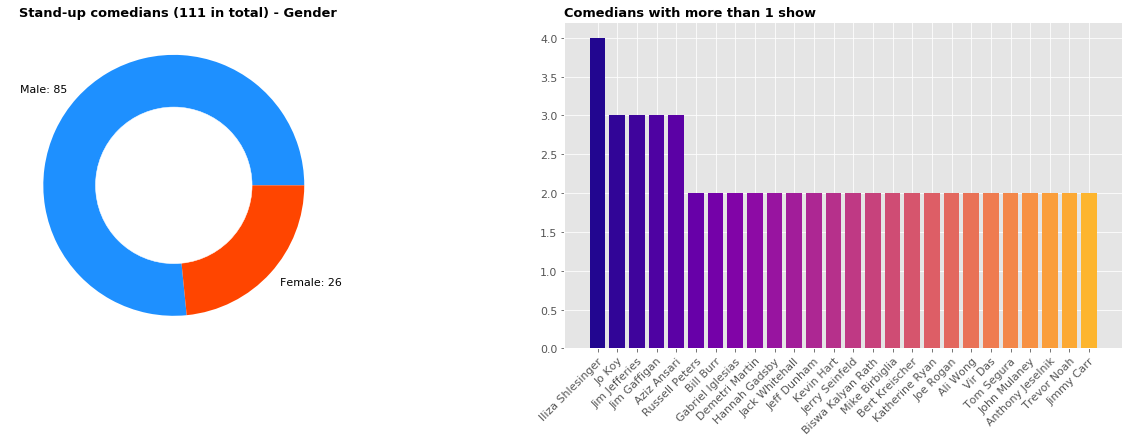

In [13]:
## General EDA charts panel (2) - Stand-up comedians

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))#set subplot and fig size

## AX1 - Number of comedians and gender

comedians = df.drop_duplicates(subset=['Comedian'], keep='first') # Retain unique comedian names
gender_num = list(comedians['Gender'].value_counts()) 
lbls = ['Male: {}'.format(gender_num[0]), 'Female: {}'.format(gender_num[1])]
colors = ['dodgerblue', 'orangered']

ax1.pie(gender_num, labels=lbls, colors=colors)
ax1.add_artist(plt.Circle((0, 0), 0.6, color='white')) # white circle at the centre
ax1.set_title('Stand-up comedians ({} in total) - Gender'.format(df['Comedian'].nunique()), fontweight='bold', fontsize=13, loc='right')


## AX2- Comedian with more than 1 show

com_shows_group = df.groupby('Comedian')['Title'].count().sort_values(ascending=False)
com_shows_num = com_shows_group[com_shows_group >= 2]
com_shows_lbl = com_shows_group[com_shows_group >= 2].index

ax2.bar(com_shows_lbl, com_shows_num, color=sns.color_palette("plasma", 30))
ax2.set_title('Comedians with more than 1 show', fontweight='bold', fontsize=13, loc='left')
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

## 2.2) NLP data exploration 

### 2.2.1) Fundamental text characteristics
The EDA on the fundamental characteristics of the stand-up comedy scripts reveals that:

- Looking at the text data, the vocabulary's size (i.e., the total number of unique words including stopwords) over the whole document corpus is 35747 words. The stand-up show scripts included in the sample have on average 9366 words with a distribution that ranges between 2985-13535 words. With respect to sentences, the average is 1067 and a distribution that ranges between 499-1856 sentences.

- Despite the unbalance with respect to comedian gender ratio and number of shows per comedian, the preliminary frequency analysis of tokens and sentences does not reveal sizeable differences in the overall script's lenght between male and female comedians. One observable difference is that male comedians tend to use more sentences per script (average number of sentences per script around 1100) compared to women (around 900 of sentences per script).

- Similarly, the breakdown of the distribution by producer does not highlight relevant differences between the Netflix and Amazon groups.

- In terms of content, the analysis of the most common "clean" tokens (i.e., tokenized text without stopwords) using Wordclouds does not reveal substantial differences in the most common words used by male and female commedians.

In [14]:
# Import libraries
from tqdm import tqdm
import spacy
import itertools
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

In [15]:
# Load spaCy pipeline with the default settings for English
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('sentencizer', before="ner") # Add sentencizer component to count sentences

# Correct some common word contractions to accomodate tokenizer
df['Text'] = df['Text'].str.replace('gonna', 'going to') # gonna => going to
df['Text'] = df['Text'].str.replace('gotta', 'have to') # gotta => have to
df['Text'] = df['Text'].str.replace("'re", " are") # 're => are

# Prepare list of documents to pass to spaCy pipeline
doc_list = list(df.iloc[:, 6])

print('Number of documents:', len(doc_list))
print('\nSpaCy English language model (small) - Pipeline components:', nlp.pipe_names)

Number of documents: 143

SpaCy English language model (small) - Pipeline components: ['tok2vec', 'tagger', 'parser', 'sentencizer', 'ner', 'attribute_ruler', 'lemmatizer']


In [16]:
# Loop to define:
token_num = [] # Token count per document
sent_num = [] # Sentence count per document
tokens_clean = [] # List of tokens per document (excluding punctuation, white spaces and stopwords)
tokens_stopw = [] # List of stop words per document 


# N.B. disable unnecessary spaCy pipeline components
for doc in tqdm(nlp.pipe(doc_list, disable=["tok2vec", "tagger", "parser", "ner", "attribute_ruler", "lemmatizer"], batch_size=30)): 
    
    # Tokenize text of each document (excluding punctuation) and separate stopwords
    word_tokens = [token.orth_ for token in doc if not token.is_punct | token.is_space | token.is_stop]
    word_stopw = [token.orth_ for token in doc if token.is_stop]
    tokens_clean.append(word_tokens)
    tokens_stopw.append(word_stopw)
    
    # Sentencize text of each document
    sentence_tokens = [sentence.text for sentence in doc.sents]
    
    # Append counts
    token_num.append(len(word_tokens)+len(word_stopw))
    sent_num.append(len(sentence_tokens))


# Add to dataframe
df['Token_count'] = pd.Series(token_num)
df['Sentence_count'] = pd.Series(sent_num)
df['Tokens_clean'] = pd.Series(tokens_clean)
df['Tokens_stopw'] = pd.Series(tokens_stopw)


# Vocabulary of the whole corpus of documents (i.e., list of unique tokens)
tokens_docs = list(set(list(itertools.chain(*tokens_clean))))
stopw_docs = list(set(list(itertools.chain(*tokens_stopw))))
vocab_docs = tokens_docs + stopw_docs

143it [00:14,  9.82it/s]


Total number of words (including stopwords) over the entire document corpus: 1339303 

Vocabulary size (i.e., number of unique tokens including stopwords) over the entire document corpus: 35746 

Average number of words per show (including stopwords): 9366 

Min-Max number of words per show (including stopwords): 2985 - 13535 



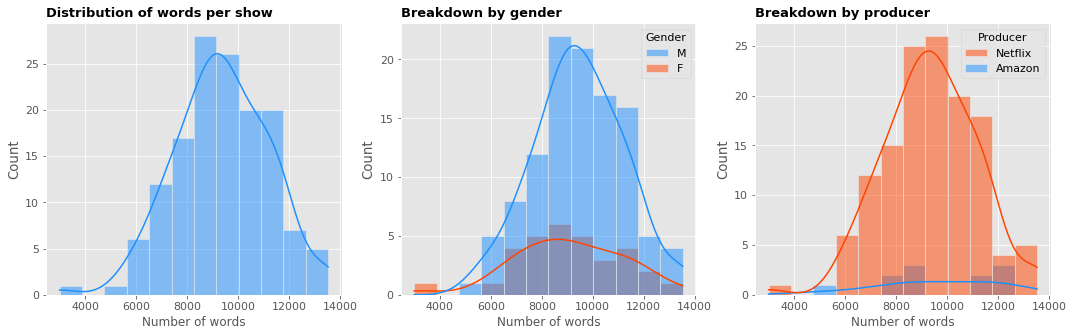

In [17]:
## Histograms text lenght (word count per show)

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5)) #set subplot and fig size

# Define number of words per document
words_num = df['Token_count']

print('\033[1m' + 'Total number of words (including stopwords) over the entire document corpus:' + '\033[0m', words_num.sum(), '\n\n'
      '\033[1m' + 'Vocabulary size (i.e., number of unique tokens including stopwords) over the entire document corpus:' + '\033[0m', len(vocab_docs), '\n\n'
      '\033[1m' + 'Average number of words per show (including stopwords):' + '\033[0m', round(words_num.mean()), '\n\n'
      '\033[1m' + 'Min-Max number of words per show (including stopwords):' + '\033[0m', round(words_num.min()), '-', round(words_num.max()), '\n')

# AX1 Histogram full sample

ax1 = sns.histplot(data=df, x=words_num, color='dodgerblue', ax=ax1, kde=True)
ax1.set_title('Distribution of words per show', fontweight='bold', fontsize=13, loc='left')
ax1.set_xlabel('Number of words', fontsize=12)

# AX2 Histogram split by gender

ax2 = sns.histplot(data=df, x=words_num, hue='Gender', palette=['dodgerblue', 'orangered'], ax=ax2, kde=True)
ax2.set_title('Breakdown by gender', fontweight='bold', fontsize=13, loc='left')
ax2.set_xlabel('Number of words', fontsize=12)

# AX3 Histogram split by producer

ax3 = sns.histplot(data=df, x=words_num, hue='Producer', palette=['orangered', 'dodgerblue'], ax=ax3, kde=True)
ax3.set_title('Breakdown by producer', fontweight='bold', fontsize=13, loc='left')
ax3.set_xlabel('Number of words', fontsize=12)

plt.show()

Total number of sentences over the whole document corpus: 152636 

Average number of sentences per show: 1067 

Minimum-Maximum number of sentences: 499 - 1856 



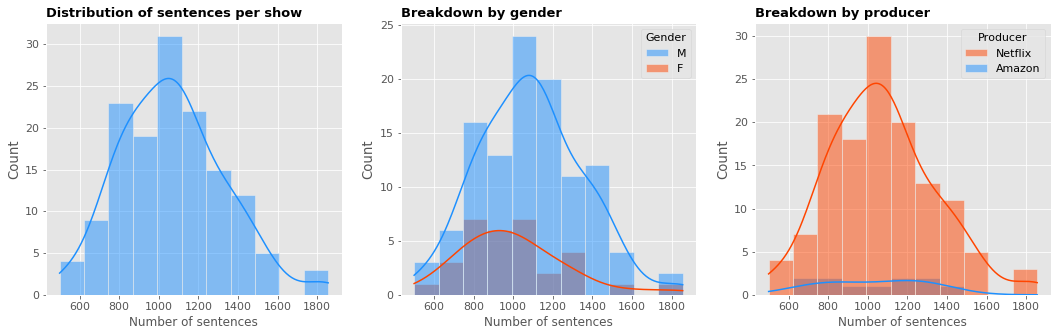

In [18]:
## Histograms sentence lenght (sentence count per show)

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5)) #set subplot and fig size

# Define number of sentences per show
sentences_num = df['Sentence_count']

print('\033[1m' + 'Total number of sentences over the whole document corpus:' + '\033[0m', round(sentences_num.sum()), '\n\n'
      '\033[1m' + 'Average number of sentences per show:' + '\033[0m', round(sentences_num.mean()), '\n\n'
      '\033[1m' + 'Minimum-Maximum number of sentences:' + '\033[0m', round(sentences_num.min()), '-', round(sentences_num.max()), '\n')

# AX1 Histogram full sample

ax1 = sns.histplot(data=df, x=sentences_num, color='dodgerblue', ax=ax1, kde=True)
ax1.set_title('Distribution of sentences per show', fontweight='bold', fontsize=13, loc='left')
ax1.set_xlabel('Number of sentences', fontsize=12)

# AX2 Histogram split by gender

ax2 = sns.histplot(data=df, x=sentences_num, hue='Gender', palette=['dodgerblue', 'orangered'], ax=ax2, kde=True)
ax2.set_title('Breakdown by gender', fontweight='bold', fontsize=13, loc='left')
ax2.set_xlabel('Number of sentences', fontsize=12)

# AX3 Histogram split by producer

ax3 = sns.histplot(data=df, x=sentences_num, hue='Producer', palette=['orangered', 'dodgerblue'], ax=ax3, kde=True)
ax3.set_title('Breakdown by producer', fontweight='bold', fontsize=13, loc='left')
ax3.set_xlabel('Number of sentences', fontsize=12)

plt.show()

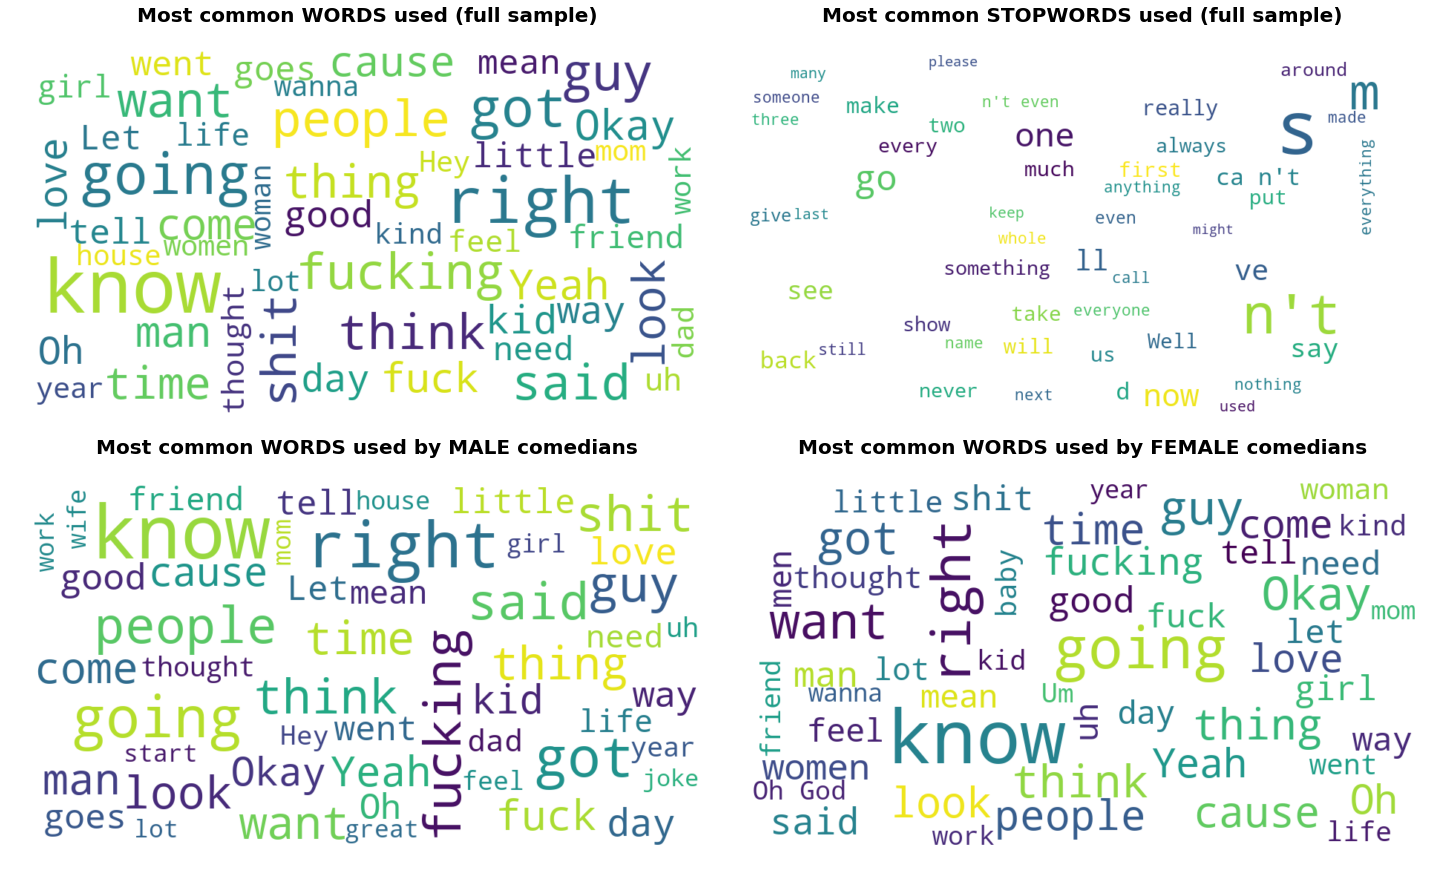

In [19]:
## Word Clouds clean tokens and stopwords

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 10 # set default font size

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))#set subplot and fig size

# AX1

# Merge list of lists in a unique list of tokens
tokens_clean_list = list(itertools.chain(*df['Tokens_clean']))
tokens_clean_list = " ".join(tokens for tokens in tokens_clean_list)

# Word Cloud
wordcloud_1 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(tokens_clean_list)

ax[0,0].imshow(wordcloud_1, interpolation='bilinear')
ax[0,0].axis("off")
ax[0,0].set_title('Most common WORDS used (full sample)\n', fontweight='bold', fontsize=20)


# AX2

# Merge list of lists in a unique list
tokens_stopw_list = list(itertools.chain(*df['Tokens_stopw']))
tokens_stopw_list = " ".join(tokens for tokens in tokens_stopw_list)

# Word Cloud
wordcloud_4 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(tokens_stopw_list)

ax[0,1].imshow(wordcloud_4, interpolation='bilinear')
ax[0,1].axis("off")
ax[0,1].set_title('Most common STOPWORDS used (full sample)\n', fontweight='bold', fontsize=20)

# AX3

# Merge list of lists in a unique list of tokens
tokens_clean_M = list(itertools.chain(*df[df['Gender']=='M']['Tokens_clean']))
tokens_clean_M = " ".join(tokens for tokens in tokens_clean_M)

# Word Cloud
wordcloud_2 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(tokens_clean_M)

ax[1,0].imshow(wordcloud_2, interpolation='bilinear')
ax[1,0].axis("off")
ax[1,0].set_title('Most common WORDS used by MALE comedians\n', fontweight='bold', fontsize=20)

# AX4

# Merge list of lists in a unique list of tokens
tokens_clean_F = list(itertools.chain(*df[df['Gender']=='F']['Tokens_clean']))
tokens_clean_F = " ".join(tokens for tokens in tokens_clean_F)

# Word Cloud
wordcloud_3 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(tokens_clean_F)

ax[1,1].imshow(wordcloud_3, interpolation='bilinear')
ax[1,1].axis("off")
ax[1,1].set_title('Most common WORDS used by FEMALE comedians\n', fontweight='bold', fontsize=20)

plt.tight_layout(pad=0)
plt.show()

### 2.2.2) Advanced EDA of text data

In this sub-section, I will exploit more advanced components of the SpaCy preprocessing pipeline such as the Part-Of-Speech (POS) tagger, the dependency parser and the lemmatizer. These tools allow to refine the cleaning of the tokens and help in getting some hints on the content of the stand-up shows.

I will first check the frequency of noun-chunks which are defined as "base noun phrases", i.e. noun plus neighbor words describing it such as adjectives+noun or article+noun. In this case, I will consider only noun-chunks that are made of at at least 2 words in order to obtain meaningful results. Afterwards, I will use POS tagger and lemmatizer to filter tokens and have a closer look at the most common proper nouns, nouns and adjectives used in stand-up comedy.

The main takeaways from the analysis are:
- Both the frequency analysis of noun-chunks and the WordCloud of tokens tagged as nouns by POS tagging reveal many references to general people (e.g., kid, guys, girl, women, men), family related nouns (e.g., mom, dad, wife, baby, child, friend) and other words such as "life" and "love". These elements suggest that personal stories, daily-life experiences & anecdotes are probably one of the most common topics discussed in stand-up comedy.

- In addition, the Wordcloud of the proper nouns identified with POS tagging suggests the presence of other potential topics such as satire on politics (e.g., Bill Clinton, Donald Trump, White House, United States), celebrities (e.g., Michael Jackson), religion (e.g., God, Jesus, Christ), national (e.g., American, Mexican, Indian) and racial (e.g., nigga) groups. However, it must be noted that words such as "God" and "Jesus" are also very common English exclamations which could be the main reason behind their high frequency in the corpus.

In [20]:
# Detailed summary of spaCy pipeline components and attributes
pipe_analysis = nlp.analyze_pipes(pretty=True)


============================= Pipeline Overview =============================

#   Component         Assigns               Requires   Scores             Retokenizes
-   ---------------   -------------------   --------   ----------------   -----------
0   tok2vec           doc.tensor                                          False      
                                                                                     
1   tagger            token.tag                        tag_acc            False      
                                                                                     
2   parser            token.dep                        dep_uas            False      
                      token.head                       dep_las                       
                      token.is_sent_start              dep_las_per_type              
                      doc.sents                        sents_p                       
                                                       sents

In [21]:
# Loop to define:

pos_propn = [] # List of lemmatized tokens with POS=proper noun 
pos_noun = [] # List of lemmatized tokens with POS=noun          
pos_adj = [] # List of lemmatized tokens with POS=adjective
noun_chuncks = [] # List of noun chunks per document (i.e., flat phrases that have a noun as their head)


# N.B. disable unnecessary spaCy pipeline components
for doc in tqdm(nlp.pipe(doc_list, disable=["ner", "sentencizer"], batch_size=3)):
    
    # Extract lemma of proper nouns 
    propn = [token.lemma_ for token in doc if token.pos_=='PROPN']
    pos_propn.append(propn)
    
    # Extract lemma of nouns 
    nouns = [token.lemma_ for token in doc if token.pos_=='NOUN']
    pos_noun.append(nouns)
    
    # Extract lemma of adjectives 
    adj = [token.lemma_ for token in doc if token.pos_=='ADJ']
    pos_adj.append(adj)
       
    # Extract noun-chunks made of at least 2 tokens
    chuncks = [chunck.text for chunck in doc.noun_chunks if len(chunck) > 1]
    noun_chuncks.append(chuncks)

# Add to dataframe

df['POS_propn'] = pd.Series(pos_propn)
df['POS_noun'] = pd.Series(pos_noun)
df['POS_adj'] = pd.Series(pos_adj)
df['Noun_chunk'] = pd.Series(noun_chuncks)

143it [03:34,  1.50s/it]


In [22]:
# Merge noun-chunks lists in a unique list of noun chuncks, lowercase strings and count them
chuncks_unique = list(itertools.chain(*df['Noun_chunk']))
noun_chuncks_full = Counter([x.lower() for x in chuncks_unique])
chuncks_all = pd.DataFrame.from_dict(noun_chuncks_full, orient='index').rename(columns={0: "Num_chuncks"})

chuncks_all.sort_values('Num_chuncks', ascending=False).head()

,Num_chuncks
a lot,911
you guys,665
the fuck,663
the world,505
my wife,495


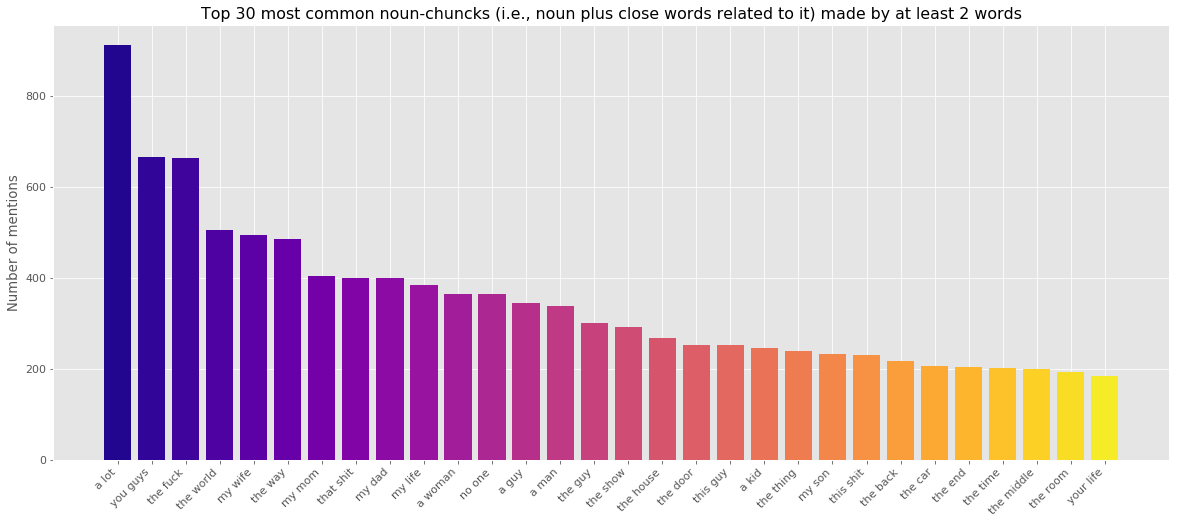

In [23]:
## Noun chuncks bar chart

# Plot
plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig = plt.figure(figsize=(20, 8))#set subplot and fig size

plt.bar(np.arange(30), chuncks_all.sort_values('Num_chuncks', ascending=False).head(30)['Num_chuncks'], color=sns.color_palette("plasma", 30))
plt.xticks(np.arange(30), chuncks_all.sort_values('Num_chuncks', ascending=False).head(30).index, rotation=45, ha="right")
plt.ylabel('Number of mentions')
plt.title('Top 30 most common noun-chuncks (i.e., noun plus close words related to it) made by at least 2 words')

plt.show()

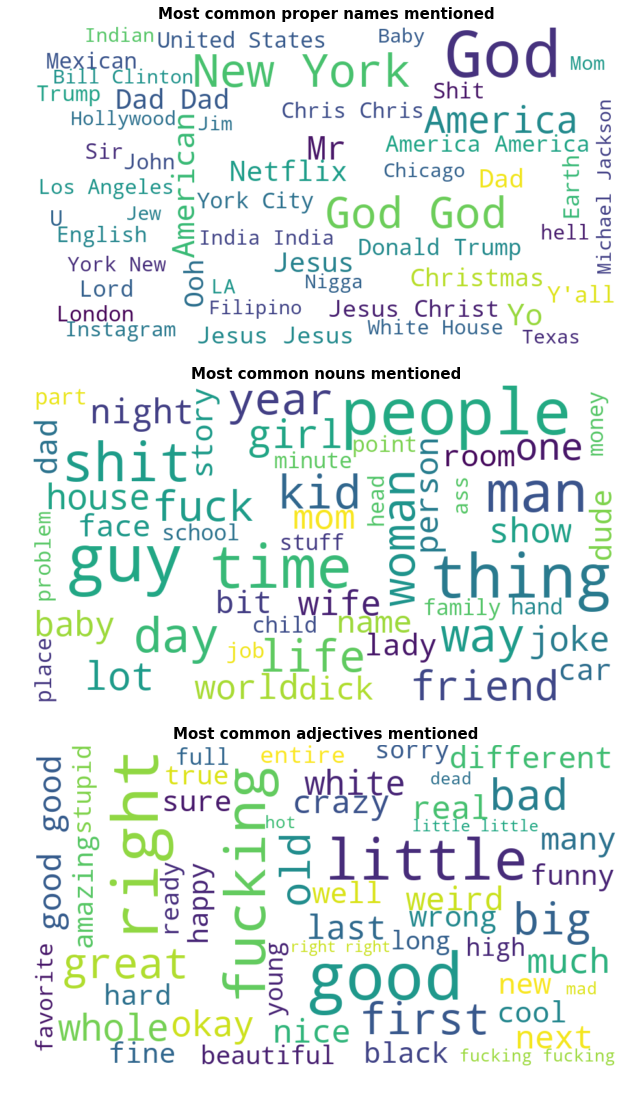

In [24]:
## Word Clouds tokens with on POS== PROPN, NOUN and ADJ

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 10 # set default font size

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))#set subplot and fig size

# AX1 PROPN

# Merge list of lists in a unique list of tokens
PROPN_clean_list = list(itertools.chain(*df['POS_propn']))
PROPN_clean_list = " ".join(tokens for tokens in PROPN_clean_list)

# Word Cloud
wordcloud_1 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(PROPN_clean_list)

ax[0].imshow(wordcloud_1, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('Most common proper names mentioned', fontweight='bold', fontsize=15)


# AX2

# Merge list of lists in a unique list of tokens
NOUN_clean_list = list(itertools.chain(*df['POS_noun']))
NOUN_clean_list = " ".join(tokens for tokens in NOUN_clean_list)

# Word Cloud
wordcloud_2 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(NOUN_clean_list)

ax[1].imshow(wordcloud_2, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title('Most common nouns mentioned', fontweight='bold', fontsize=15)

# AX3

# Merge list of lists in a unique list of tokens
ADJ_clean_list = list(itertools.chain(*df['POS_adj']))
ADJ_clean_list = " ".join(tokens for tokens in ADJ_clean_list)

# Word Cloud
wordcloud_3 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(ADJ_clean_list)

ax[2].imshow(wordcloud_3, interpolation='bilinear')
ax[2].axis("off")
ax[2].set_title('Most common adjectives mentioned', fontweight='bold', fontsize=15)

plt.tight_layout(pad=0)
plt.show()

# 3) Topic modelling
In this section, I will try to give a more robust answer to the question **"What are the most common topics discussed in stand-up comedy?"**. To do this, I will use 3 different techniques to investigate deeper into the hints provided from the EDA:

   - 3.1) I will use statistical Named-Entity-Recognition (NER) from the `en_core_web_md` language model of the `SpaCy` library to further investigate the content of the scripts identifying the most common public figures, geographical areas, nationalities, religious or political groups discussed across all stand-up shows.
   - 3.2) I will employ Latent Dirichlet Allocation (LDA) on the term frequency matrix (built using the bag-of-words method) to extract latent topics and assess their relevance across the 143 stand-up comedy scripts.
   - 3.3) After vectorizing texts and building a term frequency–inverse document frequency (tf-IDF) matrix, I will reduce the features' dimensionality with principal component analysis (PCA) and I will fine-tune a k-means algorithm using the elbow method to identify the optimal number of `k` clusters of topics.
   
The outcomes of NER, LDA and k-means models are in line with the hints retrieved from the EDA. Anecdotes about personal experiences, daily-life situations and family are by far the most common topic in stand-up comedy. However, the extent of this topic category and its diversity in terms of stories/characters involved makes the data very noisy and it is therefore not possible to breakdown this class in a small number of neat and defined topics. Furthermore, the fact that most comedians tackle a mix of topics in each show (from personal stories, to politics and sex) complicates this distinction even more.

The analysis carried out in this section also finds confirmation of the fact that both satire on politicians, national & religious groups and on sex/relationships are popular topics discussed in stand-up routines. Interestingly, scripts that deal with the former type of comedy are those that distinguish themself more easily compared to the rest of the scripts in the sample. This happens probably because most of the comedians specialised on these type of topic tend to discuss them more consistenly throughout the entire show.

## 3.1) Named Entity Recognition (NER)
Named-entity recognition (NER) is the task of identifying and categorizing key information (entities) in text. An entity can be any real-world object, such as persons, locations, organizations, products, etc., that can be denoted with a proper name.

Here I will use the Named Entity Recognizer model of the [SpaCy medium language model](https://github.com/explosion/spacy-models/releases//tag/en_core_web_md-3.0.0) to parse the stand-up scripts and extract named entities. This pre-trained NER model has been trained on texts like blog articles, news, comments. It comes with a precision of 0.86 (ENTS_P), a recall (ENTS_R) and a F-score (ENTS_F) of 0.85 respectively.

The steps are:
- 1) parsing documents using the NER model of the spaCy language model and store all the results in a dataframe;
- 2) analysing frequency of the entities found in corpus and intepret the results.

The insights obtained from the NER model are:

- The NER model finds a total number of 10517 unique named entities across the whole document corpus. The most common entity category mentioned in stand-up shows are: people (PERSON); cardinal numbers (CARDINAL); dates (DATE); geopolitical entities (GPE) like countries, cities, states; nationalities, religious and political groups (NORP); Organizations (ORG). Considering the type of text under analysis, PERSON, GPE, NORP and ORG constitute the most interesting categories to investigate in more detail.

- Notice also that the NER model doesn't have bullet-proof accuracy and mistakenly considers some tokens as named entities (e.g., "yo", "bitch", "Y'all", "Uhhuhu") or misclassifies them (e.g., Facebook is considered a PERSON instead of as an ORG and the opposite happens for O.J. Simpson).

- The fact that PERSON is the most common named-entity category by far (3688 unique entities and over 11000 mentions) confirms the hypotheses made at EDA stage. Among the most mentioned PERSON entities there are common names (e.g., dad), politicians (e.g., Donald Trump, Barack, Hitler, Bill Clinton), celebrities (e.g., Michael Jackson) and many other proper names. What also emerges from the NER analysis is that the average number of mentions for each unique PERSON entity is actually quite low (around 3.19 mentions per entity) compared to those of named-entities from other categories like NORP and GPE. This means that the diversity of stories and characters is very high and therefore topic extraction/summarization tecniques (especially those based on token-frequency only) might encounter some difficulties in defining neat and well-defined topics.    

- References to English-speaking countries/states/cities (e.g., America, Canada, United States, California, LA, New York, India) constitute the majority of the geographic/geopolitical entities (GPE) mentioned in stadn-up comedy confirming also in this case the intial insights obtained from the EDA. 

- In terms of nationalities/political groups (NORP), Americans, Indian, Asian, Chinese, Mexican as well as European nationalities are among the most popular groups mentioned in stand-up comedy.

- With respect to organizations (ORG), references to terrorist organizations (i.e., ISIS), video services(e.g., Youtube, Neflix), social media (e.g., Instagram, Pinterest, WhatsApp) and popular consumer brands (e.g., McDonalds, Disney, Starbucks, Ferrari) are among the most commonly mentioned.

- Finally, NER also confirms that no sizeable differences exists among male and female commedians in terms of entities mentioned.

In [25]:
# Load spaCy medium English language model (it has higher precision compared to the en_small model)
nlp_NER = spacy.load("en_core_web_md", disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])

# Show pipeline
NER_medium_model = nlp_NER.analyze_pipes(pretty=True)


============================= Pipeline Overview =============================

#   Component   Assigns          Requires   Scores          Retokenizes
-   ---------   --------------   --------   -------------   -----------
0   ner         doc.ents                    ents_f          False      
                token.ent_iob               ents_p                     
                token.ent_type              ents_r                     
                                            ents_per_type              

✔ No problems found.


In [26]:
## Apply NER model to find entities

ents_text = [] # Entity found in text
ents_label = [] # Entity type
ents_id = [] # Document ID
ents_desc = [] # Description of the entity type

for text, doc_num in tqdm(zip(doc_list, range(0, len(doc_list)))):
    
    # Keep track of the doc ID for each extracted entity 
    doc = nlp_NER(text)
    ents_id.append([doc_num]*len(doc.ents))
    
    # Extract named entity, entity type and description 
    for ent in doc.ents:
        ents_text.append(ent.text)
        ents_label.append(ent.label_)
        ents_desc.append(str(spacy.explain(ent.label_)))
        

# Join all the output in a dataframe
ent_id_unique = list(itertools.chain(*ents_id))
entities = pd.DataFrame(list(zip(ent_id_unique, ents_text, ents_label, ents_desc)), columns =['Doc_id', 'Entity', 'Ent_label', 'Ent_desc']) 
entities.head()

143it [01:36,  1.48it/s]


,Doc_id,Entity,Ent_label,Ent_desc
0,0,Adam Devine,PERSON,"People, including fictional"
1,0,tonight,TIME,Times smaller than a day
2,0,today,DATE,Absolute or relative dates or periods
3,0,Ham,PERSON,"People, including fictional"
4,0,two months,DATE,Absolute or relative dates or periods


In [27]:
## Correct some entities values
entities['Entity'].replace('Trump', 'Donald Trump', inplace=True)
entities = entities[entities['Entity'] != 'Shit']

#### Entities mentioned by type

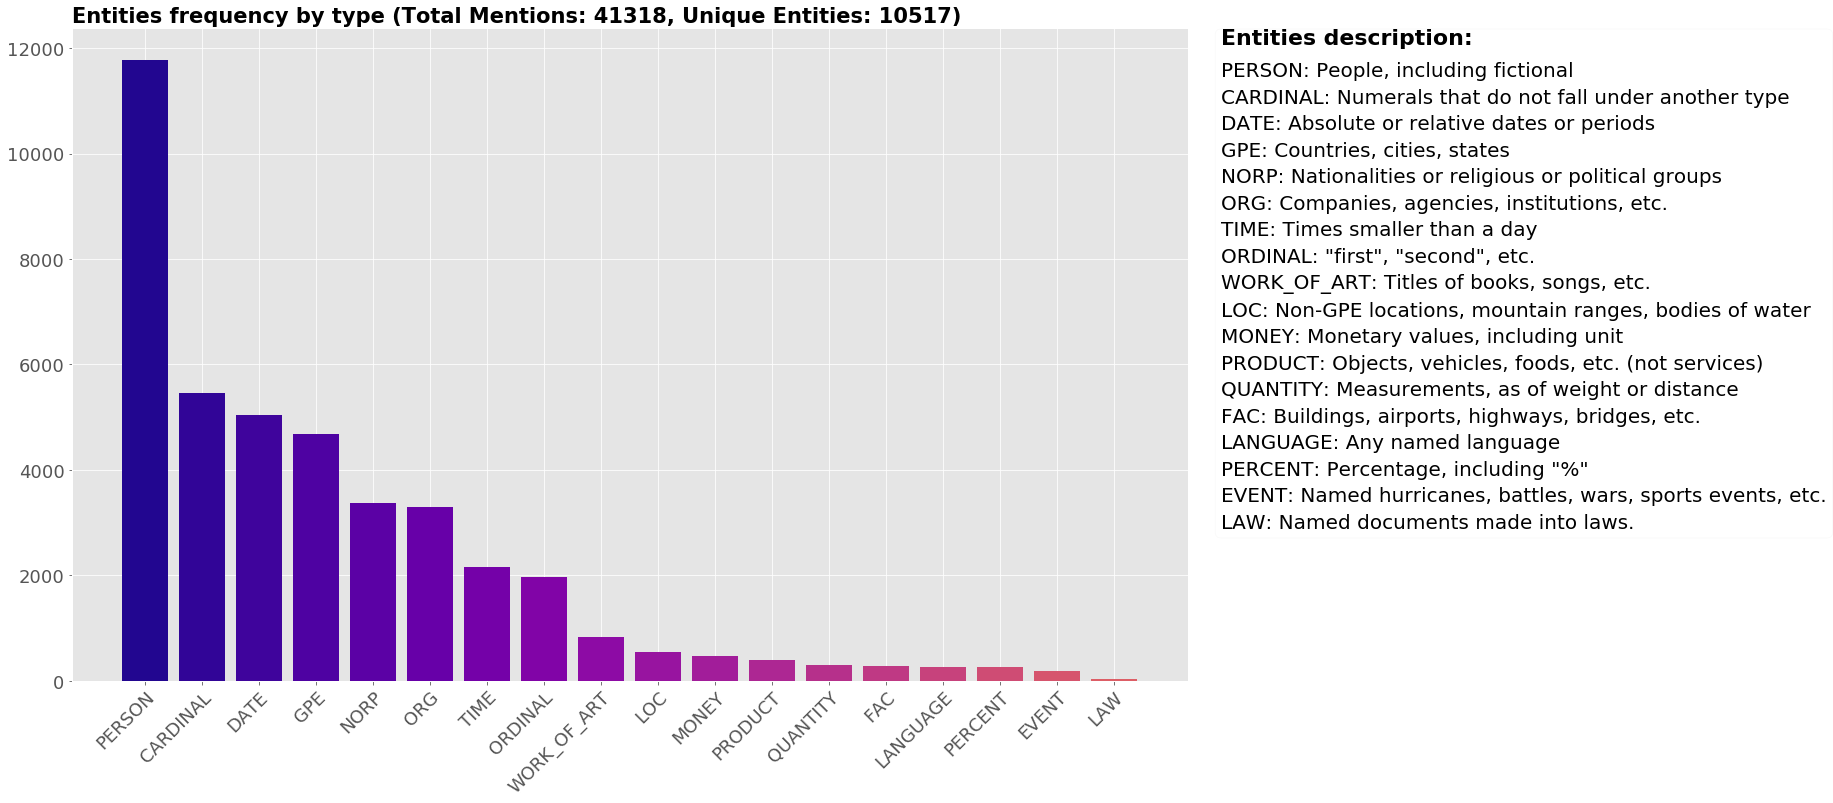

In [28]:
## Bar chart - Entities frequency by type

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 18 # set default font size

fig, ax = plt.subplots(1, 1, figsize=(20, 12))#set subplot and fig size

# Define numbers, labels and text box with data description
ent_group = entities.groupby(['Ent_label', 'Ent_desc'])['Ent_label'].agg(['count']).reset_index().sort_values('count', ascending=False)
ent_num = ent_group['count']
ent_lbl = ent_group['Ent_label']
ent_desc = ent_group[['Ent_label', 'Ent_desc']].agg(': '.join, axis=1)

# Chart
ax.bar(ent_lbl, ent_num, color=sns.color_palette("plasma", 30))
ax.set_title('Entities frequency by type (Total Mentions: {}, Unique Entities: {})'
             .format(len(entities), entities['Entity'].nunique()), fontweight='bold', fontsize=21, loc='left')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

props = dict(boxstyle='round', facecolor='white', alpha=0.5) # Matplotlib.patch.Patch properties
textstr = '\n'.join(ent_desc) # Join in a unique piece of text
ax.text(1.03, 0.99, '\n'+textstr, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props, linespacing=1.5)
ax.text(1.03, 1.00, 'Entities description:', transform=ax.transAxes, fontsize=22, fontweight='bold', verticalalignment='top')

plt.show()

In [29]:
# Number of unique entities per category
print('Number of unique PERSON entities: ', entities[entities['Ent_label']=='PERSON']['Entity'].nunique())
print('\n', 'Number of unique GPE entities: ', entities[entities['Ent_label']=='GPE']['Entity'].nunique())
print('\n', 'Number of unique NORP entities: ', entities[entities['Ent_label']=='NORP']['Entity'].nunique())
print('\n', 'Number of unique ORG entities: ', entities[entities['Ent_label']=='ORG']['Entity'].nunique())

# Average number of mentions per entity in the corpus
print('\n\n', 'Average number of mentions per PERSON entity: ', list(ent_group[ent_group['Ent_label']=='PERSON']['count'].values/entities[entities['Ent_label']=='PERSON']['Entity'].nunique()))
print('\n', 'Average number of mentions per GPE entity: ', list(ent_group[ent_group['Ent_label']=='GPE']['count'].values/entities[entities['Ent_label']=='GPE']['Entity'].nunique()))
print('\n', 'Average number of mentions per NORP entity: ', list(ent_group[ent_group['Ent_label']=='NORP']['count'].values/entities[entities['Ent_label']=='NORP']['Entity'].nunique()))
print('\n', 'Average number of mentions per ORG entity: ', list(ent_group[ent_group['Ent_label']=='ORG']['count'].values/entities[entities['Ent_label']=='ORG']['Entity'].nunique()))

Number of unique PERSON entities:  3688

 Number of unique GPE entities:  796

 Number of unique NORP entities:  380

 Number of unique ORG entities:  1583


 Average number of mentions per PERSON entity:  [3.195227765726681]

 Average number of mentions per GPE entity:  [5.886934673366834]

 Average number of mentions per NORP entity:  [8.860526315789473]

 Average number of mentions per ORG entity:  [2.07706885660139]


#### Most mentioned entities

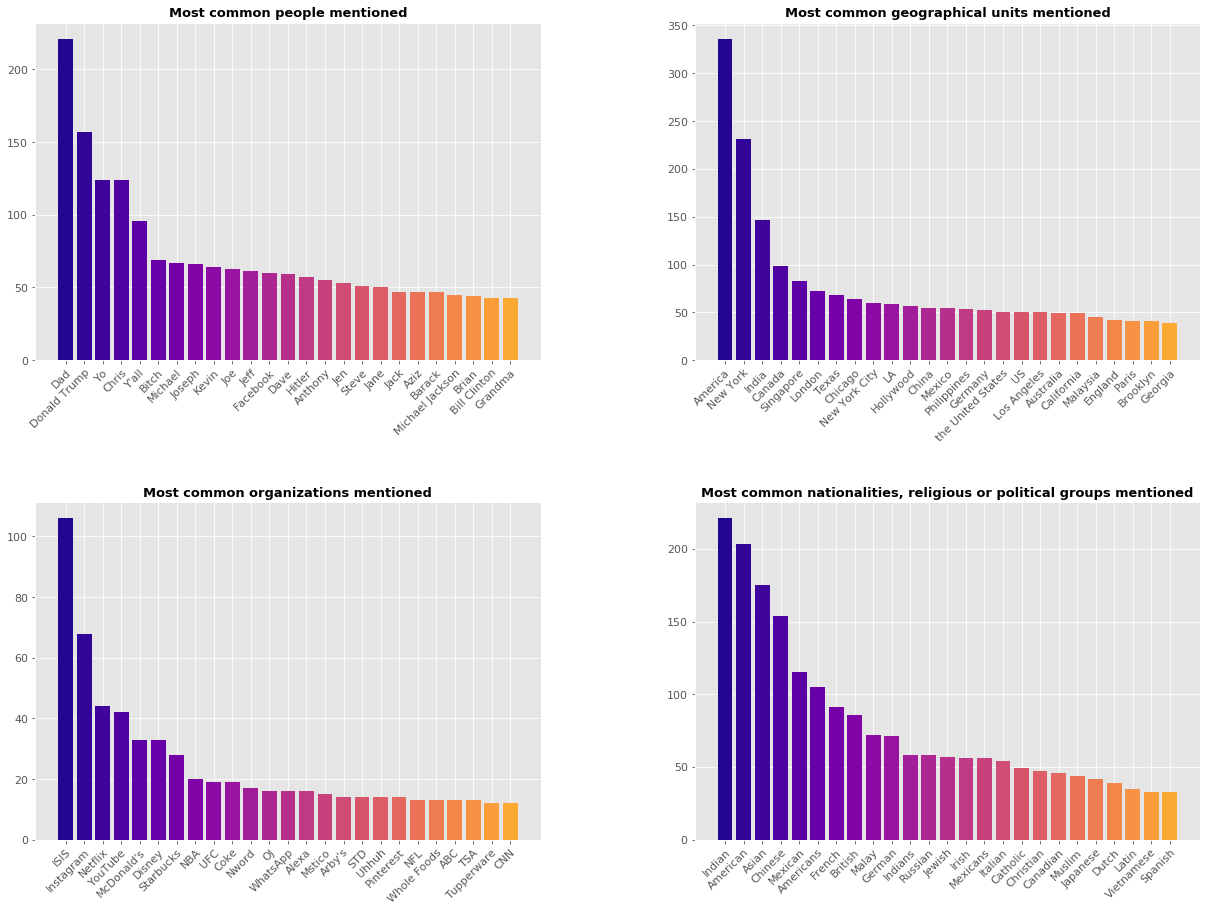

In [30]:
## Bar charts - Most cited entities (top 25)

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))#set subplot and fig size
fig.tight_layout(pad=11.0)


# AX1 PERSON
person_num = entities[entities['Ent_label']=='PERSON']['Entity'].value_counts().head(25)
person_lbl = entities[entities['Ent_label']=='PERSON']['Entity'].value_counts().head(25).index

ax[0,0].bar(person_lbl, person_num, color=sns.color_palette("plasma", 30))
ax[0,0].set_title('Most common people mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[0,0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX2 GPE

GPE_num = entities[entities['Ent_label']=='GPE']['Entity'].value_counts().head(25)
GPE_lbl = entities[entities['Ent_label']=='GPE']['Entity'].value_counts().head(25).index

ax[0,1].bar(GPE_lbl, GPE_num, color=sns.color_palette("plasma", 30))
ax[0,1].set_title('Most common geographical units mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[0,1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX3 ORG

ORG_num = entities[entities['Ent_label']=='ORG']['Entity'].value_counts().head(25)
ORG_lbl = entities[entities['Ent_label']=='ORG']['Entity'].value_counts().head(25).index

ax[1,0].bar(ORG_lbl, ORG_num, color=sns.color_palette("plasma", 30))
ax[1,0].set_title('Most common organizations mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[1,0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX4 NORP

NORP_num = entities[entities['Ent_label']=='NORP']['Entity'].value_counts().head(25)
NORP_lbl = entities[entities['Ent_label']=='NORP']['Entity'].value_counts().head(25).index

ax[1,1].bar(NORP_lbl, NORP_num, color=sns.color_palette("plasma", 30))
ax[1,1].set_title('Most common nationalities, religious or political groups mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[1,1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


plt.show()

In [31]:
# Select indeces for male/female comedians
male_coms = list(df[df['Gender']=='M'].index)
fem_coms = list(df[df['Gender']=='F'].index)

#### Most mentioned entities by male comedians

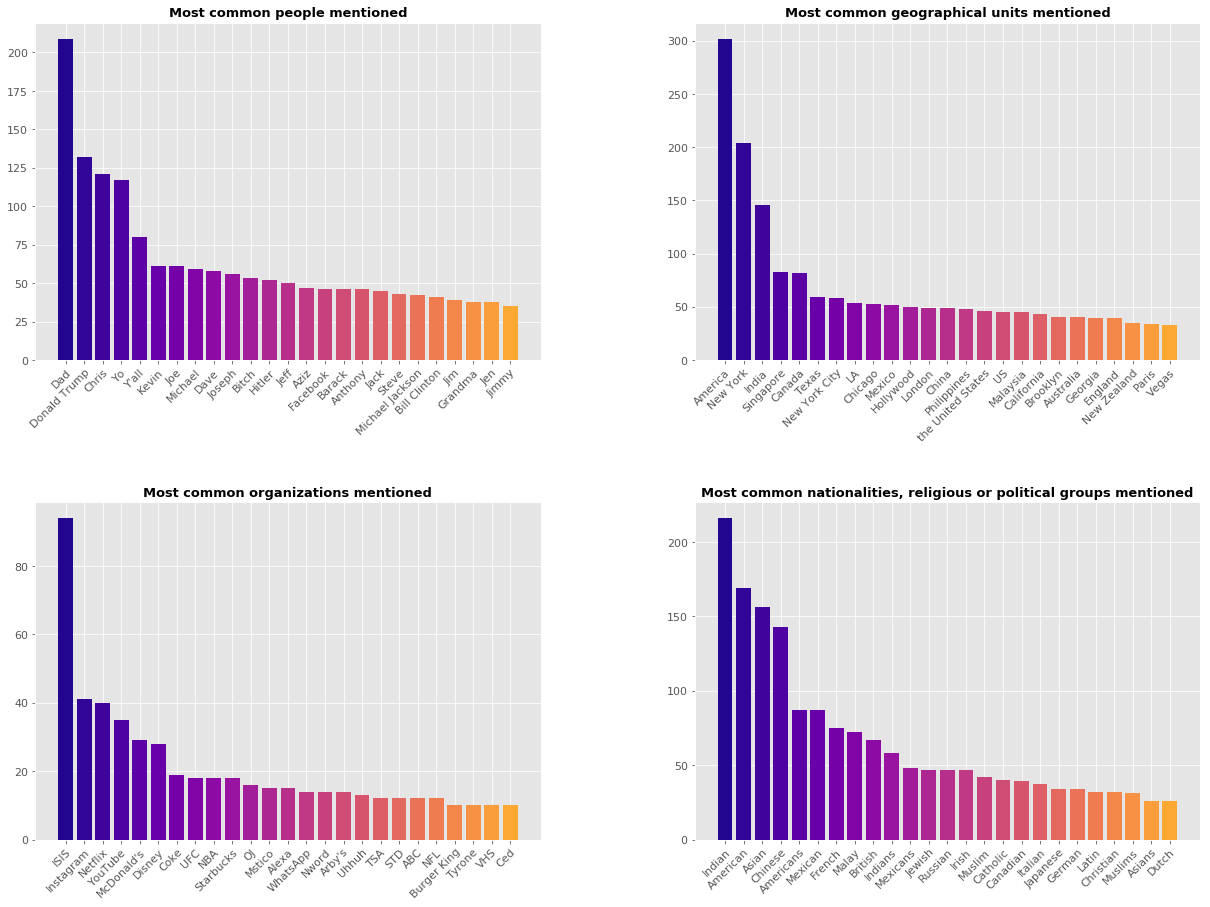

In [32]:
## Bar charts - Most cited entities (top 25) by MALE comedians

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))#set subplot and fig size
fig.tight_layout(pad=11.0)


# AX1 PERSON
person_num = entities[(entities['Ent_label']=='PERSON') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25)
person_lbl = entities[(entities['Ent_label']=='PERSON') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25).index

ax[0,0].bar(person_lbl, person_num, color=sns.color_palette("plasma", 30))
ax[0,0].set_title('Most common people mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[0,0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX2 GPE

GPE_num = entities[(entities['Ent_label']=='GPE') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25)
GPE_lbl = entities[(entities['Ent_label']=='GPE') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25).index

ax[0,1].bar(GPE_lbl, GPE_num, color=sns.color_palette("plasma", 30))
ax[0,1].set_title('Most common geographical units mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[0,1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX3 ORG

ORG_num = entities[(entities['Ent_label']=='ORG') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25)
ORG_lbl = entities[(entities['Ent_label']=='ORG') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25).index

ax[1,0].bar(ORG_lbl, ORG_num, color=sns.color_palette("plasma", 30))
ax[1,0].set_title('Most common organizations mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[1,0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX4 NORP

NORP_num = entities[(entities['Ent_label']=='NORP') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25)
NORP_lbl = entities[(entities['Ent_label']=='NORP') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25).index

ax[1,1].bar(NORP_lbl, NORP_num, color=sns.color_palette("plasma", 30))
ax[1,1].set_title('Most common nationalities, religious or political groups mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[1,1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


plt.show()

#### Most mentioned entities by female comedians

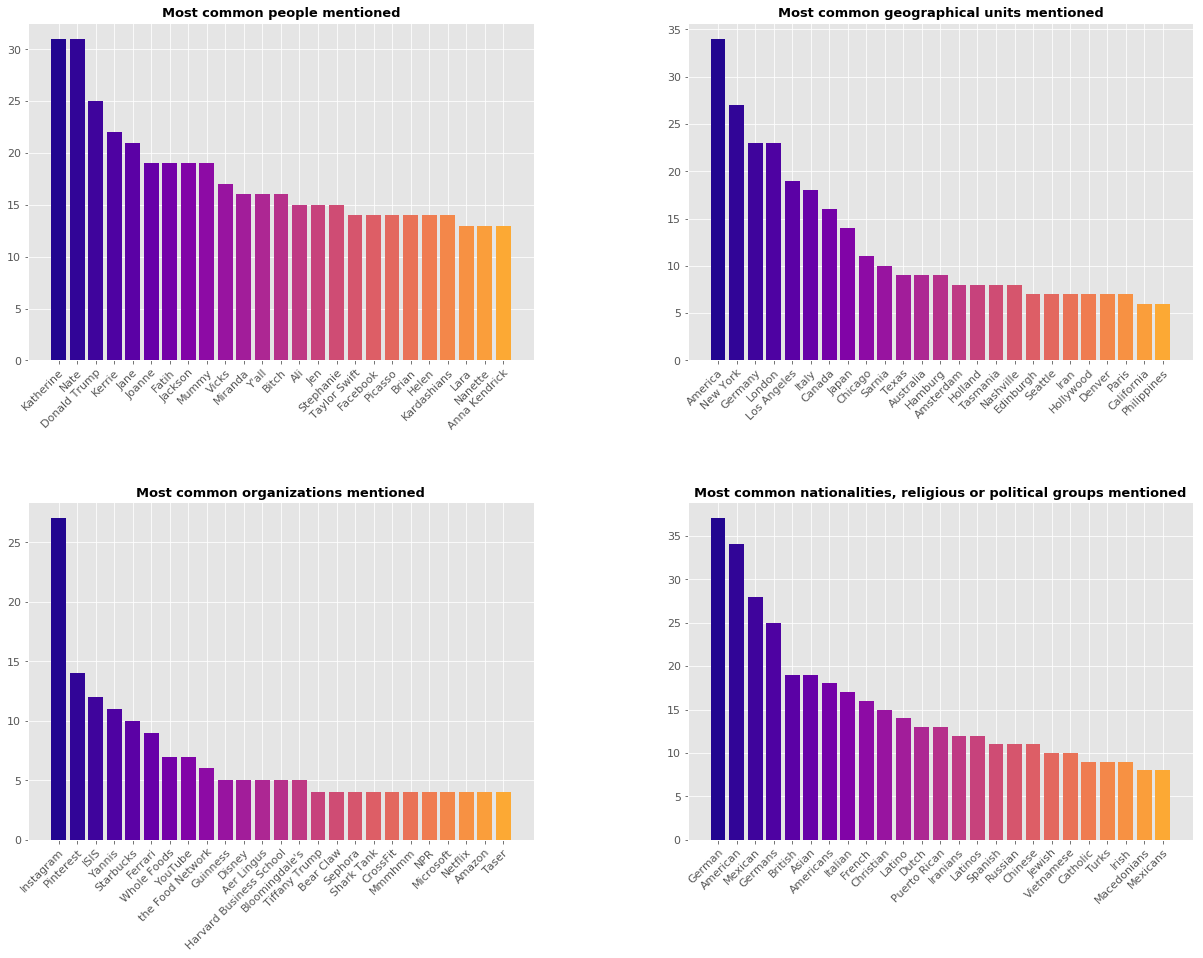

In [33]:
## Bar charts - Most cited entities (top 25) by FEMALE comedians

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))#set subplot and fig size
fig.tight_layout(pad=11.0)


# AX1 PERSON
person_num = entities[(entities['Ent_label']=='PERSON') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25)
person_lbl = entities[(entities['Ent_label']=='PERSON') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25).index

ax[0,0].bar(person_lbl, person_num, color=sns.color_palette("plasma", 30))
ax[0,0].set_title('Most common people mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[0,0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX2 GPE

GPE_num = entities[(entities['Ent_label']=='GPE') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25)
GPE_lbl = entities[(entities['Ent_label']=='GPE') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25).index

ax[0,1].bar(GPE_lbl, GPE_num, color=sns.color_palette("plasma", 30))
ax[0,1].set_title('Most common geographical units mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[0,1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX3 ORG

ORG_num = entities[(entities['Ent_label']=='ORG') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25)
ORG_lbl = entities[(entities['Ent_label']=='ORG') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25).index

ax[1,0].bar(ORG_lbl, ORG_num, color=sns.color_palette("plasma", 30))
ax[1,0].set_title('Most common organizations mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[1,0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX4 NORP

NORP_num = entities[(entities['Ent_label']=='NORP') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25)
NORP_lbl = entities[(entities['Ent_label']=='NORP') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25).index

ax[1,1].bar(NORP_lbl, NORP_num, color=sns.color_palette("plasma", 30))
ax[1,1].set_title('Most common nationalities, religious or political groups mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[1,1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


plt.show()

## 3.2) Latent-Dirichlet-Allocation (LDA)

In this section, I apply LDA on the 143 stand-up comedy scripts via `sklearn`. LDA is a common probabilistic statistical model used for topic extraction from a a set of unknown documents. It implicitly assumes that each document is a mix of a defined number of topics and each topic is composed by a certain set of words. The model is fed with a simple term-frequency (tf) matrix that can be obtained converting each text document to a vector of token counts.

The steps in this section will therefore involve:
- 1) Create term-frequency matrix of token counts using the CountVectorizer function.
- 2) Set the number of components (supposed number of topics) and run LDA model.
- 3) Plot the most frequent tokens for each of the topics and calculate perplexity score.

Based on EDA and NER results, I have initially assumed that the expected number of topics discussed in the stand-up corpus could be summarized in 4 distinct macro-areas: personal stories/anecdotes from daily life; politics; sex & relationships; satire on different religious/ethnic/racial groups.   

However, after testing various filtering levels for the tf matrix (e.g., increasing/restricting the minimum/maximum document frequency that tokens need to have to be retained in the tf matrix by the CountVectorizer) as well as different number of topics, the most reasonable (and least "perplexed" in terms of perplexity score) LDA model identifies 3 fairly distinct topics:
- Topic 1: Personal stories/anecdotes from daily life. This is suggested by the frequency of tokens such as wife, movie, food, dog, dude, etc.
- Topic 2: Satire on politics and ethnic/racial groups. This is suggested by the frequency of tokens such as black, president, country, Trump, America.
- Topic 3: Sex and relationships. This is suggested by the frequency of tokens such as dick, ass, wife, girls, gay.

These results suggest that satire on politicians and national/ethnic/racial groups are very interrelated. An example in this sense are the stand-up shows of comedians such as Dave Chapelle.

In [34]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from time import time

In [35]:
## Define and fit CountVectorizer

# Set parameters
n_features = 100


# Set custom stopwords
my_stop_words = text.ENGLISH_STOP_WORDS.union(['uh', 'wanna', 'dont', 'im', 'thats',
                                               'um', 'hes', 'aint', 'ain', 'em', 'huh',
                                               'chris', 'shit', 'cause', 'okay', 'hey',
                                               'doesn', 'fuck', 'fucking', 'yes', 'ha',
                                               'isn', 'fuckin', 'gentlemen', 'going',
                                               'right', 'll', 'yeah', 'oh',
                                               'like', 'know', 'just', 've', 'don',
                                               'got', 'says', 'bit', 'ok', 'actually'])


# Create term frequency matrix (tf) of features for LDA
print("Creating term frequency (tf) matrix...")

tf_vectorizer = CountVectorizer(
    max_df=0.75, # Ignore terms that have a doc frequency higher than this threshold
    min_df=0.15, # Ignore terms that have a doc frequency lower than this threshold
    max_features=n_features, stop_words=my_stop_words)

t0 = time()

# Fit vectorizer on documents
tf = tf_vectorizer.fit_transform(doc_list)

print("Completed in %0.3fs." % (time() - t0))

Creating term frequency (tf) matrix...
Completed in 0.748s.


In [36]:
## Define and fit LDA model

# Ser parameters
n_components = 3 # Number of topics
n_top_words = 10
n_samples = 143

print("Fitting LDA models using term frequency matrix, " "n_samples=%d and n_features=%d..." % (n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_components, max_iter=5, learning_method='online', learning_offset=50., random_state=0)

t0 = time()
lda.fit(tf)
print("Completed in %0.3fs." % (time() - t0))

Fitting LDA models using term frequency matrix, n_samples=143 and n_features=100...
Completed in 0.830s.


In [37]:
# Define plotting function for topics and keywords

def plot_top_words(model, tf_matrix, feature_names, n_top_words, title):
    '''Plotting function for resulting top n_th topics and top n_th keywords
    from the LDA model run with sklearn'''
    
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title + ' - Perplexity score: {}'.format(round(model.perplexity(tf_matrix), 0)), fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

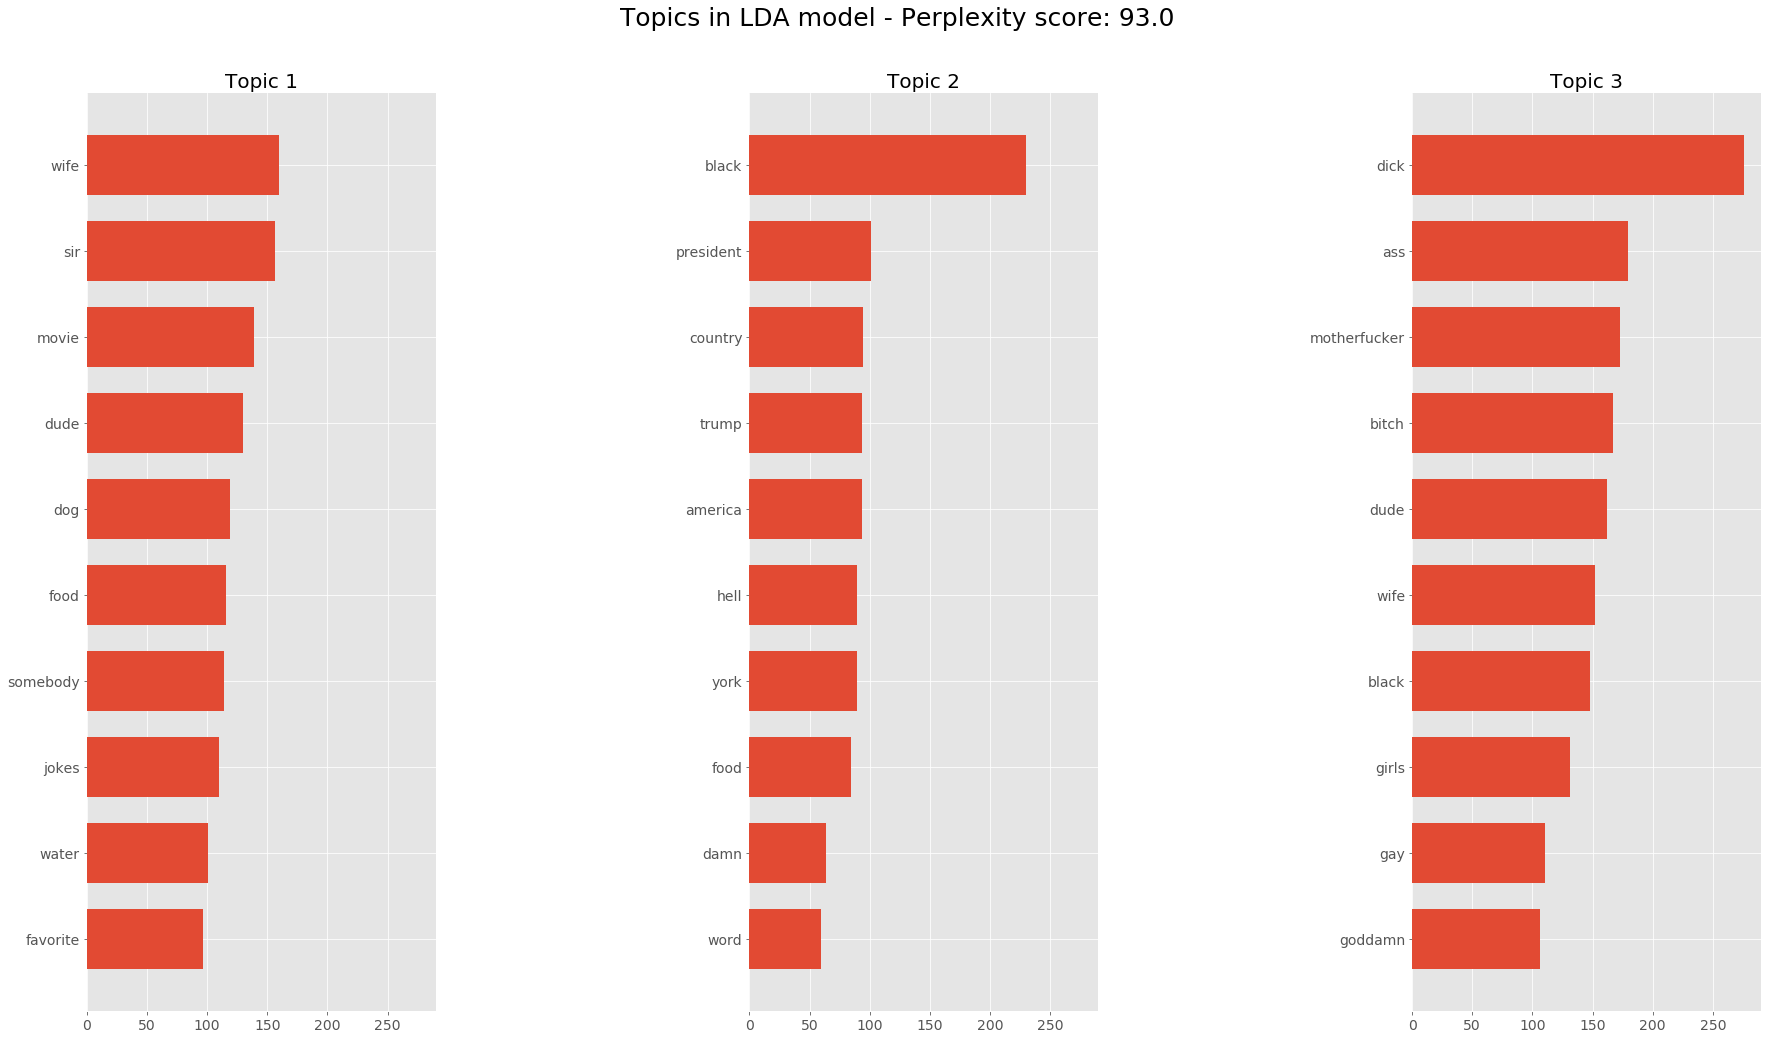

In [38]:
## Plot LDA topics

# Get tf features labels
tf_feature_names = tf_vectorizer.get_feature_names()

# Plot
plot_top_words(lda, tf, tf_feature_names, n_top_words, 'Topics in LDA model')

## 3.3) PCA and k-means on tf-IDF matrix

In this section, I have adopted a different strategy to extract and summarize the main topics discussed in stand-up comedy. This strategy involves using more "standard" machine learning techniques such as PCA (for dimensionality reduction) and K-means for clustering stand-up scripts based on their term frequency–inverse document frequency (tf-IDF) matrix. Differently from the simple tf matrix from the previous section, a value in the tf-IDF matrix acts like a weight that increases proportionally to the number of times a word appears in the document and is reduced by the number of documents in the corpus that contain the word. In this way, the value of a word is adjusted when it appears more frequently across documents compared to other more "document-specific" words.

The analysis follows these steps:
- 1) Building a term frequency–inverse document frequency (tf-IDF) vector of lenght 300 for each script in the dataset using the TfidfVectorizer from sklearn.
- 2) Exploring with Principal Component Analysis (PCA) the features space and reducing the noise in the tf-IDF matrix by selecting 80 principal components (i.e., 90% of explained variance) to pass to the k-means algorithm.
- 3) Fine-tuning the k-means algorithm using the elbow method to identify the optimal number of clusters (i.e., main topics) and visualize the most relevant 10 tokens that can summarize the content of the documents in the cluster.
- 4) Visulizing the optimal clusters idenfied with k-means and elbow method on a 2-dimensional space (using only the first 2 components from the PCA).


The optimal number of clusters identified by k-means and elbow method is 6. When looking at the top 10 tokens per cluster of documents, this time is more difficult to identify a clean and neat separation among the topics. Notice that at every run of the code the clusters can be assigned a different number as label and some "top tokens" can change do to the randomness in the k-means algorithm. For this reason, in the following description, I will refer to cluster by group of top tokens identified in the last time I run the code. 

The results that emerge from this exercise are: 
- Cluster (goddamn, trump, ass, white, black, pussy, dick, bitch, motherfucker, nigga) seems to identify with the macro-area of satire on ethnic/racial groups. On the other hand, cluster (everybody, dick, jesus, wife, movie, president, trump, black, white, dude) seems to capture satire on politicians as well as ethnic/racial groups. These two clusters closely mirror Topic 2 found in the LDA model.
- Cluster (white, mom, girls, husband, sex, baby, dick, girl, men, women) and cluster (sleep, dick, dog, phone, sex, bed, kid, dad, baby, wife) seem to both fall in the category sex/relationships. However, the latter also shows tokens that might be associated more with personal stories/anecdotes.
- The remaining clusters clearly fall in the personal stories/anecdotes category with each of them hinting towards a certain type of stories. For instance, cluster (pretty, dog, funny, friend, hate, story, dad, baby, jokes, joke) seems to summarize stand-up routines related to family-related anecdotes about daily life. On the other hand, cluster (parents, york, sir, son, kid, dude, bro, indian, dad, mom) seems to group documents where personal experiences about childhood/teenagehood are discussed.
- The mixture of different topics within each stand-up comedy script (which is what makes difficult the classification/summarization of neat topics) is well represented when the clusters are plotted in a 2 dimensional space using the first 2 components from the PCA. The final scatter plot shows that the only cluster of scripts that clearly distinguish itself from the rest are those having satire on ethnic/racial groups and politicans. The other clusters are packed into a big group with most of the variability being decribed only by differences across the PC1-axis.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [40]:
# Set up vectorizer to create 
tfidf = TfidfVectorizer(
    min_df = 0.05, # Ignore terms that have a doc frequency higher than this threshold
    max_df = 0.90, # Ignore terms that have a doc frequency higher than this threshold
    max_features = 300,
    stop_words = my_stop_words
)

# Dense Tf-IFD matrix to pass to PCA (dense matrix representation of the sparse matrix obtained from TfidVectorizer)
X = tfidf.fit_transform(doc_list).todense()

print('Features matrix shape:', X.shape)

Features matrix shape: (143, 300)


In [41]:
## PCA

# Create PCA transformer
pca = PCA(n_components=None)

# Apply PCA
pca.fit(X, y=None)

# Project data onto the components
X_comp = pca.transform(X)

# Proportion of variance explained
pve = pca.explained_variance_ratio_

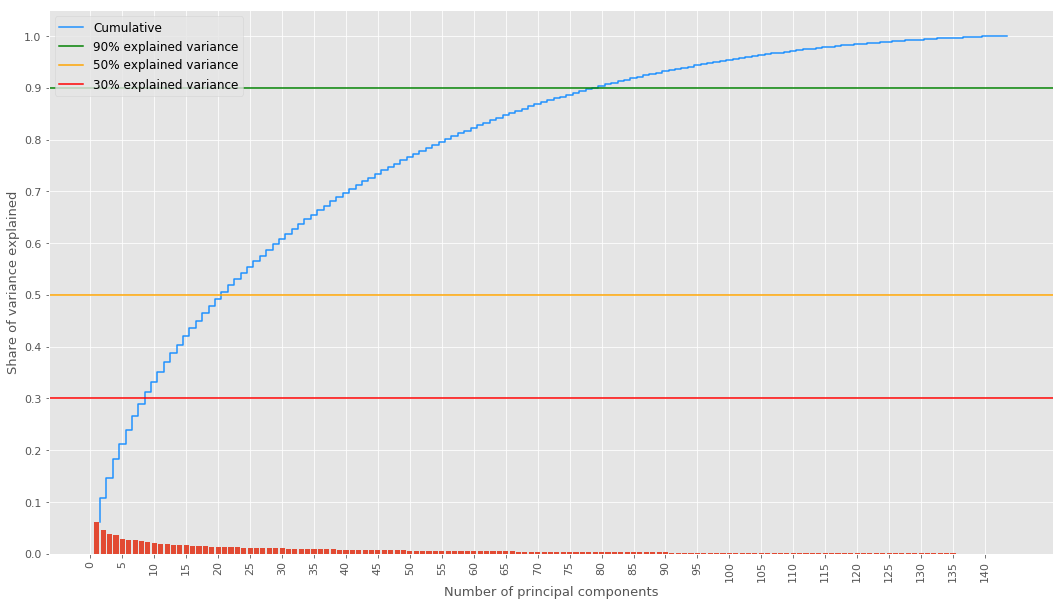

In [42]:
# Create bar plot
x_lbl = np.arange(1, len(pve) + 1) # 1,2,..,n_components
plt.figure(figsize=(18, 10))
plt.bar(x_lbl, pve)
plt.xticks(np.arange(0, len(x_lbl)+1, 5), fontsize=11, rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=11)

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(x_lbl+0.5, pve_cumsum, label='Cumulative', color='dodgerblue')

# Add horizontal line
plt.axhline(y=0.9, color='green', label='90% explained variance')
plt.axhline(y=0.5, color='orange', label='50% explained variance')
plt.axhline(y=0.3, color='red', label='30% explained variance')

plt.xlabel('Number of principal components', fontsize=13)
plt.ylabel('Share of variance explained', fontsize=13)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [43]:
# Transfrom feature matrix to pass to k-means (retain 80 components, around 90% of variability)
pca_optimal = PCA(n_components=80)
X_k_means = pca_optimal.fit_transform(X)

print('Shape features matrix for k-means (i.e., reduced tf-IDF matrix):', X_k_means.shape)

Shape features matrix for k-means (i.e., reduced tf-IDF matrix): (143, 80)


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.11it/s]


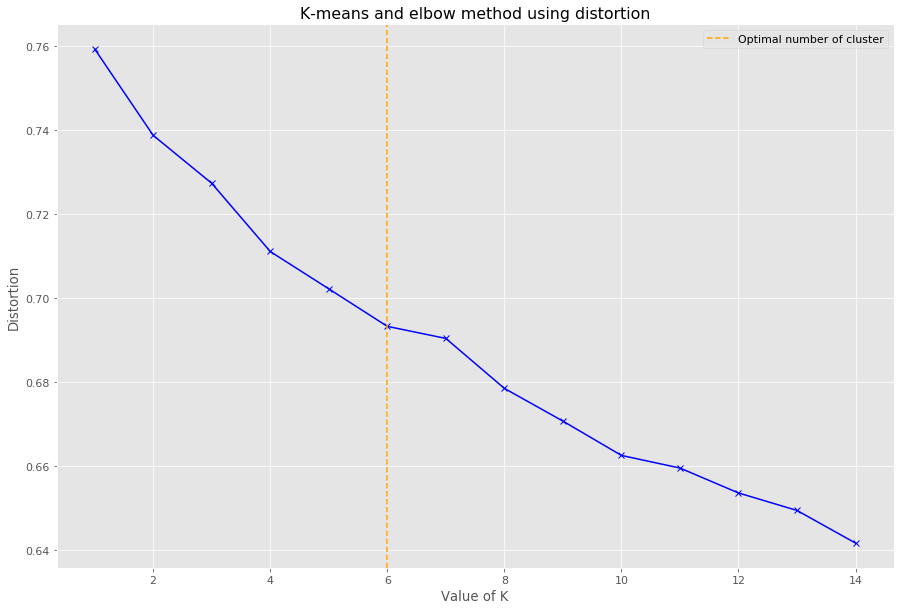

In [44]:
# Range of clusters to optimize
K = range(1, 15)

# Loop model
distortions = [] # Distortion values
inertias = [] # Inertia values

for k in tqdm(K):
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state=50)
    kmeanModel.fit(X_k_means)
 
    distortions.append(sum(np.min(cdist(X_k_means, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_k_means.shape[0])
    inertias.append(kmeanModel.inertia_)
    

# Plot distortion vs optimal number of clusters
plt.figure(figsize=(15, 10))
plt.plot(K, distortions, 'bx-')
plt.axvline(x=6, color='orange', label='Optimal number of cluster', linestyle='--')
plt.legend()
plt.xlabel('Value of K')
plt.ylabel('Distortion')
plt.title('K-means and elbow method using distortion')
plt.show()

In [45]:
# Optimal number of clusters from Elbow method
opt_clusters = 6

# Run k-means with optimal number of clusters
optimal_kmeans = KMeans(n_clusters=opt_clusters)

# Predict the labels for each script
text_lbl = optimal_kmeans.fit_predict(X_k_means)

# Get unique labels
u_labels = np.unique(text_lbl)

In [46]:
# Define function that shows top keywords per cluster
def top_keywords(data, clusters, labels, n_terms):
    '''Print the top n-th tokens for each k-means cluster'''
    
    # Average the value of tf-IDF elements per cluster 
    df = pd.DataFrame(data).groupby(clusters).mean()
    
    # Show the words with the highest values in each cluster
    for i,r in df.iterrows():
        print('\nCluster {}:\n'.format(i))
        print(', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

# Apply function
top_keywords(X, text_lbl, tfidf.get_feature_names(), 10)


Cluster 0:

pretty, dog, funny, friend, hate, story, dad, baby, jokes, joke

Cluster 1:

parents, york, sir, son, kid, dude, bro, indian, dad, mom

Cluster 2:

sleep, dick, dog, phone, sex, bed, kid, dad, baby, wife

Cluster 3:

white, mom, girls, husband, sex, baby, dick, girl, men, women

Cluster 4:

goddamn, trump, ass, white, black, pussy, dick, bitch, motherfucker, nigga

Cluster 5:

everybody, dick, jesus, wife, movie, president, trump, black, white, dude


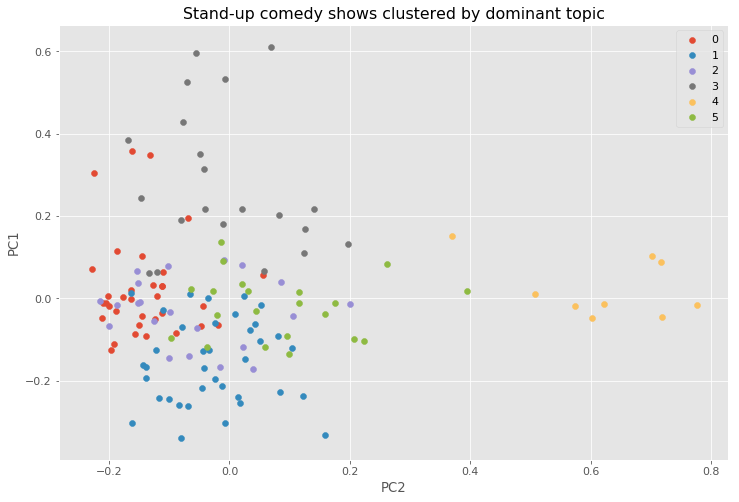

Number of documents per cluster: {1: 37, 0: 34, 5: 21, 3: 21, 2: 21, 4: 9}

Cluster 0:

pretty, dog, funny, friend, hate, story, dad, baby, jokes, joke

Cluster 1:

parents, york, sir, son, kid, dude, bro, indian, dad, mom

Cluster 2:

sleep, dick, dog, phone, sex, bed, kid, dad, baby, wife

Cluster 3:

white, mom, girls, husband, sex, baby, dick, girl, men, women

Cluster 4:

goddamn, trump, ass, white, black, pussy, dick, bitch, motherfucker, nigga

Cluster 5:

everybody, dick, jesus, wife, movie, president, trump, black, white, dude


In [47]:
## Representation of stand-up comedy clusters

# Reduce dimensionality to represent clusters in scatterplot
pca_chart = PCA(n_components=2)

X_reduced = pca_chart.fit_transform(X)

 
# Plot
plt.figure(figsize=(12, 8))
for i in u_labels:
    plt.scatter(X_reduced[text_lbl==i , 0] , X_reduced[text_lbl==i , 1] , label= i)
plt.legend()
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.title('Stand-up comedy shows clustered by dominant topic')

plt.show()


# Identify number of documents per cluster
cluster_lbl = list(pd.Series(text_lbl).value_counts().index)
cluster_num = list(pd.Series(text_lbl).value_counts().values)
cluster_desc = dict(zip(cluster_lbl, cluster_num))
print('Number of documents per cluster:', cluster_desc)

# Add cluster keywords
top_keywords(X, text_lbl, tfidf.get_feature_names(), 10)

# 4) Text generation with RNN models

IMPORTANT: NOTICE THAT THE GLOVE .TXT FILE WITH THE PRE-TRAINED WORD VECTORS COULD NOT BE UPLOADED ON GITHUB BECAUSE OF ITS SIZE (338 MB). In order to run this section the Notebook properly, the file `glove.6B.100d.txt`(GloVe - vector dimension 100, trained on Wikipedia 2014 and Gigaword 5) should be downloaded from the GloVe link provided below and inserted in the repository.

The aim of this section is to use a sample of stand-up comedy scripts to train 2 word-level models with a recurrent neural network (RNN) architecture and test their ability to generate new text $^{*}$. This means constructing models that use text sequences of a defined lenght as features to predict the next word in the sequence (i.e., y labels). In practice, the model is trained to predict the "class" of the next word in the sequence among the entire set of classes (i.e., all the words in the vocabulary).

It must be noticed that this type of task is computationally very expensive and requires a significant amount of data and training time to reach high levels of accuracy. In addition, the complexity of stand-up comedy text (i.e., rich vocabulary compared to script lenght, lots of slang/acronyms) exacerbates further this aspect.

For these reasons, I have adopted a number of measures to make the analysis feasible. First, only a subset of few similar documents has been used to train the models (specifically, all scripts included in the smallest cluster identified by k-means in section 3). Second, I kept the architecture of the RNN models as simple as possible to increase computational efficiency and reduce training time. Third, for similar reasons, I decided to use pre-trained weights from [GloVe](https://nlp.stanford.edu/projects/glove/) to embed text sequences for the deep learning models as this step dramatically reduces the number of model parameters to train.

In sum, this section is made of 4 steps:
- 4.1) Select the stand-up comedy scripts belonging to one of the clusters identified with K-means in section 3.3. Format and transform this sample of similar stand-up comedy scripts into a series of 50-words text sequences (features) followed by the 51st word in sequence (label). Each token in these sequences is then encoded as an integer. Using the encoded sequences, create training and validation sets for the models.
- 4.2) Build a pre-trained embedding matrix to pass to the deep learning models. This is done by extracting pre-trained word vectors from the Global Vectors for Word Representation text file (GloVe - vector dimension 100, trained on Wikipedia 2014 and Gigaword 5) using the word lookup table (i.e. word-integers lookup table built in 4.1). These vectors are then used as the weights of the embedding matrix in the Keras Embedding layer. This step allows to reduce sizebly the number of parameters to train for each model.
- 4.3) Define and train two RNN models (one based on LSTM cells and the other on GRU cells). After, compare their validation accuracy.
- 4.4) Use the most performing RNN model (the one with higher validation accuracy) to generate new text and confront it with the real sequence from the script.


$^{*}$ *For this section, I have drawn direct inspiration and fundamental help from the work of [Jason Brownlee](https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/).*

In [48]:
# Feature engineering
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
import random
from random import randint

# Model creation, training and text generation
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
from pickle import load

# Describe machine details and turn-off future warnings
from tensorflow.python.client import device_lib
print( 'Machine specifics:', '\n', device_lib.list_local_devices())
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

Machine specifics: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12623663323006143249
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1463015835
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16144087352801582025
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


## 4.1) Create sequences from text

In [49]:
# Extract text and make a unique list
scripts = list(df['Text'])

# Select small subsample of similar documents for text generation
clust_to_use = min(cluster_desc, key=cluster_desc.get) # select cluster with smaller number of documents
docs_idx_gen = list(np.where(text_lbl==clust_to_use)[0])

subset_scripts = [scripts[i] for i in docs_idx_gen]

print('Number of total documents (stand-up comedy scripts):', len(scripts))
print('\nNumber of scripts included in the subset:', len(subset_scripts))
print('\nList of scripts used:\n\n', df.loc[docs_idx_gen, 'Title'])

Number of total documents (stand-up comedy scripts): 143

Number of scripts included in the subset: 9

List of scripts used:

 11                    Arsenio Hall: Smart & Classy
24     Cedric the Entertainer: Live from the Ville
26                           Chris Rock: Tamborine
33                 Dave Chappelle: Sticks & Stones
83                    Katt Williams: Great America
90                      Leslie Jones: Time Machine
96                         Marlon Wayans: Woke-ish
122                      Sam Jay: 3 in the Morning
134                    Tracy Morgan: Staying Alive
Name: Title, dtype: object


In [50]:
## Define function to retain punctuation in text sequences
## and treat them as a "words" in the model

def keep_punct(script):
    """Add spaces around punctuation"""

    # Add spaces around punctuation
    script = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', script)

    # Remove double spaces
    script = re.sub(r'\s\s', ' ', script)
    return script

In [51]:
## Apply functions to retain punctuation in scripts 
formatted_docs = []

# Iterate through scripts
for s in subset_scripts:
    formatted_docs.append(keep_punct(s))

print('{} documents have been formatted to be transformed in sequences.'.format(len(formatted_docs)))

9 documents have been formatted to be transformed in sequences.


In [52]:
## Define function to transform formatted text in sequences for training

# Set parameters
SEQUENCE_LENGHT = 50

def create_sequences(texts, training_length=SEQUENCE_LENGHT, lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    
    """Turn a set of texts into sequences of integers"""

    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)

    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'The number of unique words in the vocabulary is {num_words}.')

    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)

    # Limit to sequences with more tokens then the specified training length
    seq_lengths = [len(x) for x in sequences]
    over_idx = [i for i, l in enumerate(seq_lengths) if l > (training_length + 20)]

    new_texts = []
    new_sequences = []

    # Only keep sequences with more than sequence length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])

    training_seq = []
    labels = []

    # Iterate through the sequences of tokens
    for seq in new_sequences:

        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length:i + 1]

            # Set the features and label
            training_seq.append(extract[:-1])
            labels.append(extract[-1])

    print(f'There are {len(training_seq)} training sequences with a lenght of at least {SEQUENCE_LENGHT} words.')

    # Return everything needed for setting up the model
    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels

In [53]:
# Create training sequences

word_idx, idx_word, num_words, word_counts, new_texts, sequences, features, labels = create_sequences(formatted_docs, lower=True)

The number of unique words in the vocabulary is 5767.
There are 72792 training sequences with a lenght of at least 50 words.


### Define training and validation sets

In [54]:
## Define function to split sequences in train and validation sets

# Set parameters
TRAIN_FRACTION = 0.7
RANDOM_STATE = 50

def create_train_valid(features, labels, num_words, train_fraction=TRAIN_FRACTION):
    
    """Create training and validation features and labels."""

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert features to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)
    
    # One-hot encode labels
    y_train = to_categorical(train_labels, num_classes=num_words)
    y_valid = to_categorical(valid_labels, num_classes=num_words)

    # Memory management
    import gc
    gc.enable()
    del features, labels, train_features, valid_features, train_labels, valid_labels
    gc.collect()

    return X_train, X_valid, y_train, y_valid

In [55]:
# Apply function and split sequences

X_train, X_valid, y_train, y_valid = create_train_valid(features, labels, num_words)

print('Training set features shape:', X_train.shape)
print('Training set labels shape:', y_train.shape, '\n')
print('Validation set features shape:', X_valid.shape)
print('Validation set labels shape:', y_valid.shape)

Training set features shape: (50954, 50)
Training set labels shape: (50954, 5767) 

Validation set features shape: (21838, 50)
Validation set labels shape: (21838, 5767)


## 4.2) Load pre-trained embeddings from GloVe and create embeddings matrix

Using pre-trained embeddings means we have about half the parameters to train. However, this also means that the embeddings might not be the best for our data, and there are a number of words with no embeddings. For this reason, words in the vocabulary for which a pre-trained vector is not present have been set to zero.

In [56]:
# Load in unzipped file
glove_vectors = 'GloVe_embed\glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', encoding='utf-8', comments=None)

print('Number of words vectors:', glove.shape[0], ', Size word vectors: ', glove.shape[1])

Number of words vectors: 400000 , Size word vectors:  101


In [57]:
# Separate vectors and labels
vectors = glove[:, 1:].astype('float')
words_label = glove[:, 0]

# Free up space
del glove

# Print example of word and its vector
vectors[10], words_label[10]

(array([-1.4401e-01,  3.2554e-01,  1.4257e-01, -9.9227e-02,  7.2536e-01,
         1.9321e-01, -2.4188e-01,  2.0223e-01, -8.9599e-01,  1.5215e-01,
         3.5963e-02, -5.9513e-01, -5.1635e-02, -1.4428e-02,  3.5475e-01,
        -3.1859e-01,  7.6984e-01, -8.7369e-02, -2.4762e-01,  6.5059e-01,
        -1.5138e-01, -4.2703e-01,  1.8813e-01,  9.1562e-02,  1.5192e-01,
         1.1303e-01, -1.5222e-01, -6.2786e-01, -2.3923e-01,  9.6009e-02,
        -4.6147e-01,  4.1526e-01, -3.0475e-01,  1.3710e-01,  1.6758e-01,
         5.3301e-01, -4.3658e-02,  8.5924e-01, -4.1192e-01, -2.1394e-01,
        -5.1228e-01, -3.1945e-01,  1.2662e-01, -3.1510e-01,  3.1429e-03,
         2.7129e-01,  1.7328e-01, -1.3159e+00, -4.2414e-01, -6.9126e-01,
         1.9017e-02, -1.3375e-01, -9.6057e-02,  1.7069e+00, -6.5291e-01,
        -2.6111e+00,  2.6518e-01, -6.1178e-01,  2.0950e+00,  3.8148e-01,
        -5.5823e-01,  2.0360e-01, -3.3704e-01,  3.7354e-01,  6.9510e-01,
        -1.6370e-03,  8.1885e-01,  5.1793e-01,  2.7

In [58]:
# Word lookup dictionary
word_lookup = {word: vector for word, vector in zip(words_label, vectors)}

# Define shape embedding matrix with vocaboulary size and vector size
embedding_matrix = np.zeros((num_words, vectors.shape[1]))

# Filter GloVe vectors to keep only those words that appear in the vocaboulary
# N.B. the value of zero will be assigned to the words for which an embedding is not found
not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1        

print(f'There are {not_found} words without pre-trained embeddings.')

# Normalize and convert NaN values to 0
embedding_matrix = embedding_matrix / \
    np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))

embedding_matrix = np.nan_to_num(embedding_matrix)

print('Shape embedding matrix:', embedding_matrix.shape)

There are 712 words without pre-trained embeddings.
Shape embedding matrix: (5767, 100)


In [59]:
# Free up memory space
import gc
gc.enable()
del vectors
gc.collect()

0

## 4.3) Contruct and train LTSM-RNN models

### 4.3.1) Define baseline for comparison

In order to have a term of comparison for the performance of the RNN models, I created a baseline model to make predictions over the validation labels (i.e., y_valid) using word frequencies. The average validation accuracy when predicting the next word in the validation set by using the most frequent word in the vocabulary is around 3.5%.

In [60]:
# Define baseline for comparison
np.random.seed(40)

# Number of all words
total_words = sum(word_counts.values())

# Compute frequency of each word in vocab
frequencies = [word_counts[word] / total_words for word in word_idx.keys()]
frequencies.insert(0, 0)

# Print top 10 most frequent words
frequencies[1:11], list(word_idx.keys())[0:10]

([0.03541683733377024,
  0.03347805903716447,
  0.0326588569400071,
  0.024289342180715982,
  0.020766773162939296,
  0.020657546216651647,
  0.01526446574369897,
  0.014718331012260725,
  0.01328472734223533,
  0.0113322956773436],
 ['you', 'i', 'the', 'to', 'and', 'a', 'that', 'like', 'in', 'it'])

In [61]:
# Print baseline model validation accuracy
print(f'The accuracy is {round(100 * np.mean(np.argmax(y_valid, axis = 1) == 1), 3)}%.')

The accuracy is 3.581%.


### 4.3.2) Model 1 - RNN with LTSM cells

Model 1 is a neural network based on a layer of 64 LSTM cells (see model summary for complete description of the layers). 

Unlike standard feedforward neural networks, LSTM is an artificial neural network that has feedback connections. LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. This makes LSTM suitable for predictions on sequential data such as time series or, in this case, text sequences.

The validation accuracy reached by this model is around 11.5%.

In [62]:
## Define Model_1

# Set parameters
LSTM_CELLS = 64
EPOCHS = 150
BATCH_SIZE = 1000
VERBOSE = 1

# Define architecture 
model_1 = Sequential()
model_1.add(Embedding(input_dim=num_words, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False, mask_zero=True))
model_1.add(Masking())
model_1.add(LSTM(LSTM_CELLS, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
model_1.add(BatchNormalization())
#model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(num_words, activation='softmax'))

print(model_1.summary())

# Compile model
#opt = keras.optimizers.Adam(lr=0.01)
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set Early stopping and reduce learning rate callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         576700    
_________________________________________________________________
masking (Masking)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5767)              374855    
Total params: 994,051
Trainable params: 417,223
Non-trainable params: 576,828
________________________________________________________________

In [63]:
# Fit model
hist_model_1 = model_1.fit(X_train, y_train, batch_size=BATCH_SIZE,
                           epochs=EPOCHS,
                           verbose=VERBOSE,
                           callbacks=[early_stopping, reduce_lr],
                           validation_data=(X_valid, y_valid))

Train on 50954 samples, validate on 21838 samples
Epoch 1/150
50954/50954 [==============================] - 18s 354us/step - loss: 8.5778 - acc: 0.0174 - val_loss: 8.5390 - val_acc: 0.0471
Epoch 2/150
50954/50954 [==============================] - 10s 205us/step - loss: 8.1267 - acc: 0.0464 - val_loss: 8.1868 - val_acc: 0.0517
Epoch 3/150
50954/50954 [==============================] - 10s 201us/step - loss: 7.3619 - acc: 0.0616 - val_loss: 7.6581 - val_acc: 0.0637
Epoch 4/150
50954/50954 [==============================] - 10s 201us/step - loss: 6.6438 - acc: 0.0770 - val_loss: 7.0002 - val_acc: 0.0588
Epoch 5/150
50954/50954 [==============================] - 10s 201us/step - loss: 6.1340 - acc: 0.0834 - val_loss: 6.5247 - val_acc: 0.0545
Epoch 6/150
50954/50954 [==============================] - 10s 202us/step - loss: 5.8428 - acc: 0.0876 - val_loss: 6.2686 - val_acc: 0.0578
Epoch 7/150
50954/50954 [==============================] - 10s 203us/step - loss: 5.6799 - acc: 0.0894 - val_l

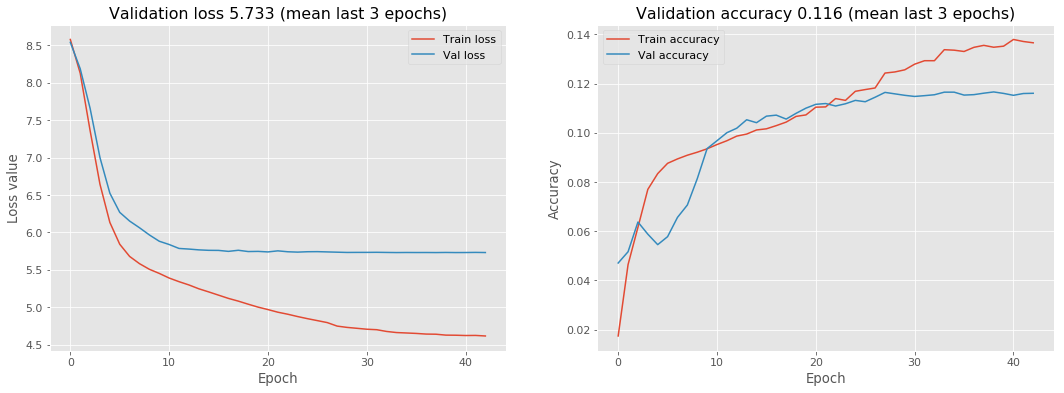

In [64]:
# Plot loss value and accuracy graphs

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot accuracy values
ax1.plot(hist_model_1.history['loss'], label='Train loss')
ax1.plot(hist_model_1.history['val_loss'], label='Val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3 epochs)'.format(
    np.mean(hist_model_1.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(hist_model_1.history['acc'], label='Train accuracy')
ax2.plot(hist_model_1.history['val_acc'], label='Val accuracy')
ax2.set_title('Validation accuracy {:.3f} (mean last 3 epochs)'.format(
    np.mean(hist_model_1.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

### 4.3.3) Model 2 - RNN with GRU cells

Model 2 is a neural network based on 1 layer of 64 GRU cells (see model summary for complete description of the layers). 

Similarly to LSTM cells, Gated Recurrent Units (GRU) have a forget gate but fewer parameters to estimate as they lack an output gate. GRUs have been shown to exhibit better performance on certain smaller and less frequent datasets so they could be ideal for this case.

The validation accuracy reached by this model is around 11%.

In [65]:
## Define Model_2

# Set parameters
GRU_CELLS = 64
EPOCHS = 150
BATCH_SIZE = 1000
VERBOSE = 1


# Define architecture 
model_2 = Sequential()
model_2.add(Embedding(input_dim=num_words, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False, mask_zero=True))
model_2.add(Masking())
#model_2.add(Bidirectional(LSTM(LSTM_CELLS, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)))
model_2.add(GRU(GRU_CELLS, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
model_2.add(BatchNormalization())
#model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(num_words, activation='softmax'))

print(model_2.summary())

# Compile model
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set Early stopping and reduce learning rate callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         576700    
_________________________________________________________________
masking_1 (Masking)          (None, None, 100)         0         
_________________________________________________________________
gru (GRU)                    (None, 64)                31680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5767)              374855    
Total params: 983,491
Trainable params: 406,663
Non-trainable params: 576,828
________________________________________________________________

In [66]:
# Fit model
hist_model_2 = model_2.fit(X_train, y_train, batch_size=BATCH_SIZE,
                           epochs=EPOCHS,
                           verbose=VERBOSE,
                           callbacks=[reduce_lr, early_stopping],
                           validation_data=(X_valid, y_valid))

Train on 50954 samples, validate on 21838 samples
Epoch 1/150
50954/50954 [==============================] - 18s 346us/step - loss: 8.5457 - acc: 0.0238 - val_loss: 8.5263 - val_acc: 0.0367
Epoch 2/150
50954/50954 [==============================] - 13s 258us/step - loss: 8.0035 - acc: 0.0559 - val_loss: 8.1671 - val_acc: 0.0422
Epoch 3/150
50954/50954 [==============================] - 12s 238us/step - loss: 7.2479 - acc: 0.0709 - val_loss: 7.6150 - val_acc: 0.0643
Epoch 4/150
50954/50954 [==============================] - 11s 217us/step - loss: 6.5528 - acc: 0.0817 - val_loss: 6.9810 - val_acc: 0.0598
Epoch 5/150
50954/50954 [==============================] - 10s 203us/step - loss: 6.1147 - acc: 0.0853 - val_loss: 6.5235 - val_acc: 0.0571
Epoch 6/150
50954/50954 [==============================] - 10s 194us/step - loss: 5.8423 - acc: 0.0878 - val_loss: 6.2773 - val_acc: 0.0598
Epoch 7/150
50954/50954 [==============================] - 10s 187us/step - loss: 5.6807 - acc: 0.0905 - val_l

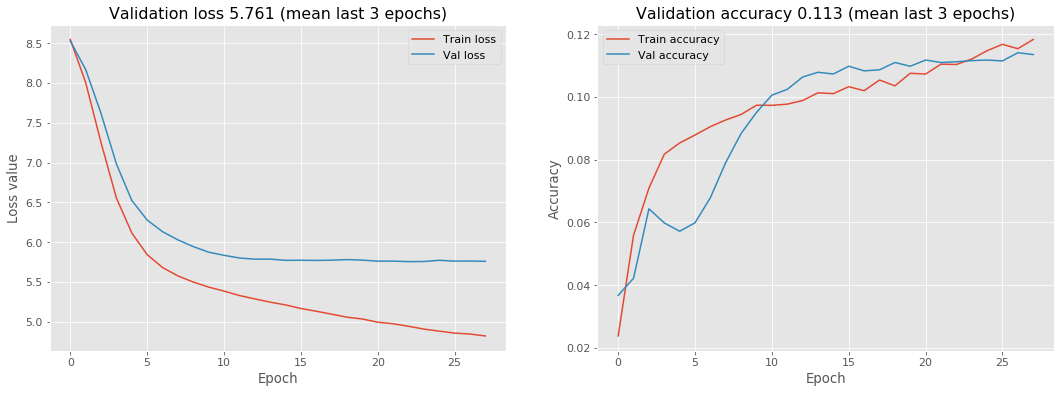

In [67]:
# Plot loss value and accuracy graphs

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot accuracy values
ax1.plot(hist_model_2.history['loss'], label='Train loss')
ax1.plot(hist_model_2.history['val_loss'], label='Val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3 epochs)'.format(
    np.mean(hist_model_2.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(hist_model_2.history['acc'], label='Train accuracy')
ax2.plot(hist_model_2.history['val_acc'], label='Val accuracy')
ax2.set_title('Validation accuracy {:.3f} (mean last 3 epochs)'.format(
    np.mean(hist_model_2.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

### 4.3.4) Comparison of models performance

The two RNN models reach very similar levels of validation accuracy. It does not seem therefore that GRU cells have an accuracy advantage in this case.

In general, the level of validation accuracy reached by the RNN models is not very high. As mentioned at the beginning of the section, the prediction task is quite complex and, for computational reasons, training sample had to be kept small. Both models are therefore trying to predict the right class/next word in the sequence out of more than 5500 classes/words using a training sample of 50000 sequences. This means, on average, that for each of the 5700 classes there are less than 10 examples present in the training data.

Nevertheless, we can see that in a short amount of time (and with a small amount of data) both RNN models become 3 times more accurate in predicting text sequences compared to the baseline model.

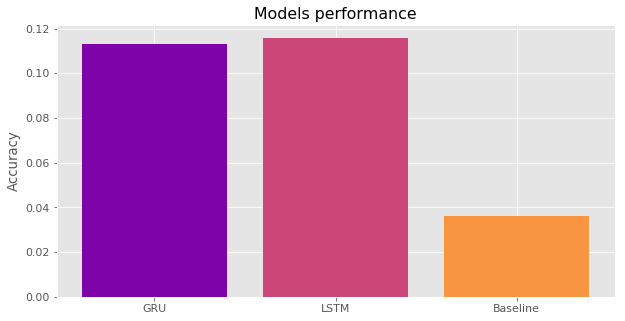

In [68]:
## Model performance bar chart

accuracy = [np.mean(hist_model_2.history['val_acc'][-3:]), # Model 2 - GRU
            np.mean(hist_model_1.history['val_acc'][-3:]), # Model 1 - LSTM
            round(np.mean(np.argmax(y_valid, axis = 1) == 1), 3)] # Baseline accuracy

models = ['GRU', 'LSTM', 'Baseline']

# Plot
plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig = plt.figure(figsize=(10, 5))#set subplot and fig size

plt.bar(np.arange(3), accuracy, color=sns.color_palette("plasma", 3))
plt.xticks(np.arange(3), models, ha="center")
plt.ylabel('Accuracy')
plt.title("Models performance")

plt.show()

## 4.4) Generate text

Finally, the best performing RNN model has been employed to generate new text. In this exercise, I fed the trained RNN model with a seed sequence of text from the stand-up comedy scripts, have it make a prediction, add the predicted word to the sequence, and make another prediction for the next word. This process continues for the number of words that we want (the new_words parameter regulates this).

The comparison between the new generated text by the model and the actual sequence of text shows that the model is still far from generating meaningful human-like text. However, it is interesting to notice that despite its low level of validation accuracy, the model is still capable to produce funny sentences (although not very meaningful!).

As already mentioned, it must be noted that the model was trained on a relatively small sample (around 50000 observations) of complex text (vocabulary with over 5000 words/classes to predict) for around 30 epochs. This means that, similarly to other application cases of deep learning, the volume of data and the amount of computational power are key to improve the generation capabilities of the model.

In [69]:
# Define function to remove spaces around punctuation
def remove_spaces(script):
    '''Remove spaces around punctuation'''
    script = re.sub(r'\s+([.,;?])', r'\1', script)

    return script

In [70]:
# Define function to generate text

def generate_text(model, sequences, training_length=50, new_words=50, diversity=1, return_output=False, n_gen=1):
    
    '''Generate new text using trained model'''

    # Choose a random text sequence
    seq = random.choice(sequences)

    # Choose a random starting point
    seed_idx = random.randint(0, len(seq) - training_length - 10)

    # Ending index for seed
    end_idx = seed_idx + training_length

    gen_list = []

    for n in range(n_gen):
        # Extract the seed sequence
        seed = seq[seed_idx:end_idx]
        original_sequence = [idx_word[i] for i in seed]
        generated = seed[:] + ['#']

        # Find the actual entire sequence
        actual = generated[:] + seq[end_idx:end_idx + new_words]

        # Keep adding new words
        for i in range(new_words):

            # Make a prediction from the seed
            preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

            # Diversify
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)

            # Softmax
            preds = exp_preds / sum(exp_preds)

            # Choose the next word
            probas = np.random.multinomial(1, preds, 1)[0]

            next_idx = np.argmax(probas)

            # New seed adds on old word
            seed = seed[1:] + [next_idx]
            generated.append(next_idx)

        # Showing generated and actual script
        n = []

        for i in generated:
            n.append(idx_word.get(i, '===>'))

        gen_list.append(n)

    a = []

    for i in actual:
        a.append(idx_word.get(i, '===>'))

    a = a[training_length:]

    gen_list = [gen[training_length:training_length + len(a)] for gen in gen_list]

    if return_output:
        return original_sequence, gen_list, a

    # Print output
    seed_header = print('\033[1m' + 'Randomly drawn seed sequence:' + '\033[0m', '\n')
    seed_text = print(remove_spaces(' '.join(original_sequence)), '\n\n')

    gen_header = print('\033[91m' + 'Model 1 LSTM - Generated:' + '\033[0m', '\n')
    gen_text =  print(remove_spaces(' '.join(gen_list[0])), '\n')

    actual_header = print('\033[92m' + 'Actual text:' + '\033[0m', '\n')
    actual_text = print(remove_spaces(' '.join(a)), '\n')

    return seed_header, seed_text, gen_header, gen_text, actual_header, actual_text

In [71]:
seed_header, seed_text, gen_header, gen_text, actual_header, actual_text = generate_text(model_1, sequences, SEQUENCE_LENGHT)

Randomly drawn seed sequence: 

yeah that's gay you can't do that no more little shit like dudes you can't be talkin' to another dude on the phone and hung up talkin' about byebye that's gay man we can't say byebye to another dude dawg trip man being a father and i was talkin' about 


Model 1 LSTM - Generated: 

===> i realized i heard i'm a man i brought a dream because every was all and the time he did that an dick you got a picture of bullies a kid like how nigga struggling the most mall can is talkin' going to pack run space to right to pack 

Actual text: 

===> all the young kids with their communicating right there 'cause i've been married 16 years man i been trying my wife still be tryin' to keep a hot thing yeah my baby she a good babe too we be tryin' to keep the shit fresh so i be tryin' to 



# 5) Conclusions

This analysis aimed at exploring the content of stand-up comedy scripts from Netflix and Amazon and testing the language generation capabilites of a RNN model trained on this type of texts.

Section 1 showed how the stand-up comedy dataset for the analysis has been built using freely available data sources from the internet.

Section 2 (EDA) and 3 (Topic Modelling) showed that stand-up comedy shows are very much a cultural phenomenon diffused in English-speaking countries and for this reason very much linked to this same countries in terms of cultural, political and geographical references. The most common topics discussed by stand-up comedians are by far anecdotes about personal experiences, daily-life situations and family, followed by satire on politicians, national & religious groups and on sex/relationships. What also emerged during topic modelling is that the extent and diversity of the "personal anecdotes" topic category in terms of stories/characters involved makes the data very noisy and it is therefore not possible to breakdown this class in a smaller number of neat and defined topics. Furthermore, the fact that most comedians tackle a mix of topics in each show (from personal stories, to politics and sex) complicates making this distinction even more.

In Section 4, I used a subsample of the stand up comedy scripts to build training and validation features sets to feed into 2 RNN models based on different architectures. After this, the most accurate model has been employed to generate new text. The analysis showed that training language models and reaching high levels of accuracy is both computationally very expensive and data intensive, particularly when dealing with complex texts (i.e., rich vocabulary per given amount of text) such as stand-up comedy scripts. Nevertheless, despite the presence of these technical challenges, the RNN models produced were on average 3 times more accurate in predicting the next word in a sentence than using the simple baseline model based on the principle "use the most frequent word in the vocabulary to predict the next word in a sentence". 

Finally, the comparison between the new generated text by the model and the actual sequence of text shows that the RNN models built are still far from being able to generate meaningful human-like text.